# Action Recognition with Custom CNN

In [1]:
from torch.utils.data import DataLoader
from main import Stanford40Dataset
from torchvision import transforms
import torch

## Prepare image transformation and constants

In [2]:
# Transforms and constant definition
# Define transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
    ),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Paths to the image directory (data/train and data/test)
data_dir = 'data'
LR = 1e-3
BATCH_SIZE = 196
EPOCHS = 50
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load dataset

In [3]:
from torch.utils.data import random_split

# Instantiate the dataset and data loaders
train_dataset = Stanford40Dataset(data_dir=data_dir, split='train', transform=transform)
test_dataset = Stanford40Dataset(data_dir=data_dir, split='test', transform=transform)

numTrainSamples = int(len(train_dataset) * TRAIN_SPLIT)
numValSamples = int(len(train_dataset) * VAL_SPLIT)
(trainData, valData) = random_split(train_dataset,
                                    [numTrainSamples, numValSamples],
                                    generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(valData, batch_size=BATCH_SIZE)


Loaded 4000 images from train split.
Loaded 5532 images from test split.


# Exploration of hyperparameters with GridSearch

In [4]:
import itertools
from CustomCNN import CustomCNN
from TrainTestUtils import train, validate, make_predictions, compute_accuracy
import torch.optim as optim
import torch.nn as nn
# Parameter grid for grid search

param_grid = {
    'num_layers': [2, 3, 4],
    'base_filters': [12, 24, 48],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],
    'lr': [0.001, 0.0001],
    'epochs': [15]
}

param_combinations = list(itertools.product(*param_grid.values()))

print(f"Testing {len(param_combinations)} parameter combinations...")

# Perform grid search
best_params = None
best_accuracy = 0.0

for i, params in enumerate(param_combinations):
    num_layers, base_filters, kernel_size, pool_size, lr, epochs = params

    print(f"Testing combination {i + 1}/{len(param_combinations)}: {params}")

    model = CustomCNN(
        num_classes=40,
        num_layers=num_layers,
        base_filters=base_filters,
        kernel_size=kernel_size,
        pool_size=pool_size,
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_criteria = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss = train(model, device, loss_criteria, train_loader, optimizer, epoch)
        test_loss = validate(model, device, loss_criteria, val_loader)

    truelabels, predictions = make_predictions(model, val_loader, device)
    accuracy = compute_accuracy(truelabels, predictions)

    print(f"Validation Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")

Testing 72 parameter combinations...
Testing combination 1/72: (2, 12, 3, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.82]


Training set: Average loss: 5.460941
Validation set: Average loss: 3.751104, Accuracy: 39/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.64]


Training set: Average loss: 3.684783
Validation set: Average loss: 3.673163, Accuracy: 26/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.61]


Training set: Average loss: 3.650012
Validation set: Average loss: 3.654416, Accuracy: 40/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.65]


Training set: Average loss: 3.626937
Validation set: Average loss: 3.620786, Accuracy: 42/1000 (4%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.63]


Training set: Average loss: 3.599193
Validation set: Average loss: 3.628139, Accuracy: 55/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.63]


Training set: Average loss: 3.581850
Validation set: Average loss: 3.582782, Accuracy: 65/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.53]


Training set: Average loss: 3.550989
Validation set: Average loss: 3.568933, Accuracy: 69/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.67]


Training set: Average loss: 3.555585
Validation set: Average loss: 3.542864, Accuracy: 79/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.48]


Training set: Average loss: 3.527142
Validation set: Average loss: 3.537203, Accuracy: 80/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.59]


Training set: Average loss: 3.530302
Validation set: Average loss: 3.521307, Accuracy: 67/1000 (7%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.43]


Training set: Average loss: 3.488877
Validation set: Average loss: 3.500636, Accuracy: 76/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.52]


Training set: Average loss: 3.485952
Validation set: Average loss: 3.482522, Accuracy: 88/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.49]


Training set: Average loss: 3.471315
Validation set: Average loss: 3.479571, Accuracy: 89/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.54]


Training set: Average loss: 3.445616
Validation set: Average loss: 3.453640, Accuracy: 90/1000 (9%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.37]


Training set: Average loss: 3.432010
Validation set: Average loss: 3.455761, Accuracy: 81/1000 (8%)

Validation Accuracy: 10.7000
Testing combination 2/72: (2, 12, 3, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.69]


Training set: Average loss: 3.788496
Validation set: Average loss: 3.706233, Accuracy: 33/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.65]


Training set: Average loss: 3.689950
Validation set: Average loss: 3.625498, Accuracy: 56/1000 (6%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.61]


Training set: Average loss: 3.638158
Validation set: Average loss: 3.616582, Accuracy: 56/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.62]


Training set: Average loss: 3.612959
Validation set: Average loss: 3.578199, Accuracy: 60/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.59]


Training set: Average loss: 3.577880
Validation set: Average loss: 3.586287, Accuracy: 66/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.52]


Training set: Average loss: 3.538399
Validation set: Average loss: 3.563615, Accuracy: 70/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.34]


Training set: Average loss: 3.520984
Validation set: Average loss: 3.540885, Accuracy: 70/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.41]


Training set: Average loss: 3.502262
Validation set: Average loss: 3.511771, Accuracy: 86/1000 (9%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.43]


Training set: Average loss: 3.514235
Validation set: Average loss: 3.538791, Accuracy: 75/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.56]


Training set: Average loss: 3.497539
Validation set: Average loss: 3.489841, Accuracy: 92/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.55]


Training set: Average loss: 3.485809
Validation set: Average loss: 3.520880, Accuracy: 89/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.52]


Training set: Average loss: 3.448391
Validation set: Average loss: 3.472791, Accuracy: 91/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.57]


Training set: Average loss: 3.462263
Validation set: Average loss: 3.489993, Accuracy: 84/1000 (8%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.45]


Training set: Average loss: 3.454436
Validation set: Average loss: 3.498167, Accuracy: 82/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.34]


Training set: Average loss: 3.444983
Validation set: Average loss: 3.466179, Accuracy: 85/1000 (8%)

Validation Accuracy: 8.5000
Testing combination 3/72: (2, 12, 3, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.67]


Training set: Average loss: 3.875441
Validation set: Average loss: 3.671861, Accuracy: 39/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.65]


Training set: Average loss: 3.656767
Validation set: Average loss: 3.644152, Accuracy: 47/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.6] 


Training set: Average loss: 3.620851
Validation set: Average loss: 3.604146, Accuracy: 49/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.57]


Training set: Average loss: 3.583669
Validation set: Average loss: 3.575260, Accuracy: 61/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.59]


Training set: Average loss: 3.543328
Validation set: Average loss: 3.507810, Accuracy: 69/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.61]


Training set: Average loss: 3.518902
Validation set: Average loss: 3.518899, Accuracy: 68/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.4] 


Training set: Average loss: 3.491663
Validation set: Average loss: 3.462532, Accuracy: 86/1000 (9%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.52]


Training set: Average loss: 3.481400
Validation set: Average loss: 3.490595, Accuracy: 84/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.4] 


Training set: Average loss: 3.454077
Validation set: Average loss: 3.472629, Accuracy: 81/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.39]


Training set: Average loss: 3.423051
Validation set: Average loss: 3.418234, Accuracy: 89/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.45]


Training set: Average loss: 3.435537
Validation set: Average loss: 3.425206, Accuracy: 104/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.38]


Training set: Average loss: 3.431390
Validation set: Average loss: 3.417313, Accuracy: 98/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.29]


Training set: Average loss: 3.381914
Validation set: Average loss: 3.407861, Accuracy: 90/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.3] 


Training set: Average loss: 3.383723
Validation set: Average loss: 3.432777, Accuracy: 108/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.26]


Training set: Average loss: 3.387520
Validation set: Average loss: 3.417628, Accuracy: 116/1000 (12%)

Validation Accuracy: 9.6000
Testing combination 4/72: (2, 12, 3, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.73]


Training set: Average loss: 3.741715
Validation set: Average loss: 3.678828, Accuracy: 30/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, loss=3.67]


Training set: Average loss: 3.699109
Validation set: Average loss: 3.670487, Accuracy: 40/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.66]


Training set: Average loss: 3.669053
Validation set: Average loss: 3.634559, Accuracy: 37/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.71]


Training set: Average loss: 3.659223
Validation set: Average loss: 3.633020, Accuracy: 46/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, loss=3.66]


Training set: Average loss: 3.632279
Validation set: Average loss: 3.612575, Accuracy: 60/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, loss=3.69]


Training set: Average loss: 3.620488
Validation set: Average loss: 3.615958, Accuracy: 68/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, loss=3.61]


Training set: Average loss: 3.592356
Validation set: Average loss: 3.590836, Accuracy: 67/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.68]


Training set: Average loss: 3.591647
Validation set: Average loss: 3.565575, Accuracy: 69/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.66]


Training set: Average loss: 3.586086
Validation set: Average loss: 3.569571, Accuracy: 68/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.62]


Training set: Average loss: 3.561771
Validation set: Average loss: 3.548552, Accuracy: 76/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.55]


Training set: Average loss: 3.548439
Validation set: Average loss: 3.536284, Accuracy: 72/1000 (7%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.47]


Training set: Average loss: 3.530248
Validation set: Average loss: 3.547496, Accuracy: 77/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.55]


Training set: Average loss: 3.517631
Validation set: Average loss: 3.533360, Accuracy: 78/1000 (8%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.54]


Training set: Average loss: 3.514927
Validation set: Average loss: 3.497376, Accuracy: 76/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.45]


Training set: Average loss: 3.516103
Validation set: Average loss: 3.502814, Accuracy: 91/1000 (9%)

Validation Accuracy: 8.8000
Testing combination 5/72: (2, 12, 5, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.69]


Training set: Average loss: 3.975926
Validation set: Average loss: 3.690291, Accuracy: 25/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.688696
Validation set: Average loss: 3.687386, Accuracy: 24/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.69]


Training set: Average loss: 3.684506
Validation set: Average loss: 3.686187, Accuracy: 23/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.68]


Training set: Average loss: 3.679707
Validation set: Average loss: 3.683796, Accuracy: 25/1000 (2%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.65]


Training set: Average loss: 3.679577
Validation set: Average loss: 3.680023, Accuracy: 26/1000 (3%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.65]


Training set: Average loss: 3.675928
Validation set: Average loss: 3.684661, Accuracy: 18/1000 (2%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.67]


Training set: Average loss: 3.676349
Validation set: Average loss: 3.679146, Accuracy: 22/1000 (2%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.69]


Training set: Average loss: 3.674505
Validation set: Average loss: 3.683666, Accuracy: 20/1000 (2%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.66]


Training set: Average loss: 3.669463
Validation set: Average loss: 3.662677, Accuracy: 35/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.64]


Training set: Average loss: 3.655495
Validation set: Average loss: 3.679057, Accuracy: 36/1000 (4%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.65]


Training set: Average loss: 3.657199
Validation set: Average loss: 3.655464, Accuracy: 47/1000 (5%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.59]


Training set: Average loss: 3.637666
Validation set: Average loss: 3.632350, Accuracy: 38/1000 (4%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.67]


Training set: Average loss: 3.628003
Validation set: Average loss: 3.627081, Accuracy: 52/1000 (5%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.59]


Training set: Average loss: 3.611849
Validation set: Average loss: 3.585011, Accuracy: 58/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.51]


Training set: Average loss: 3.591495
Validation set: Average loss: 3.582852, Accuracy: 54/1000 (5%)

Validation Accuracy: 5.3000
Testing combination 6/72: (2, 12, 5, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.700692
Validation set: Average loss: 3.660485, Accuracy: 35/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.68]


Training set: Average loss: 3.651655
Validation set: Average loss: 3.621548, Accuracy: 42/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.62]


Training set: Average loss: 3.607470
Validation set: Average loss: 3.604683, Accuracy: 52/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.5] 


Training set: Average loss: 3.576683
Validation set: Average loss: 3.574809, Accuracy: 56/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.63]


Training set: Average loss: 3.541034
Validation set: Average loss: 3.529503, Accuracy: 87/1000 (9%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.52]


Training set: Average loss: 3.518312
Validation set: Average loss: 3.518024, Accuracy: 100/1000 (10%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.39]


Training set: Average loss: 3.502756
Validation set: Average loss: 3.542967, Accuracy: 82/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.61]


Training set: Average loss: 3.489698
Validation set: Average loss: 3.527327, Accuracy: 80/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.4] 


Training set: Average loss: 3.468693
Validation set: Average loss: 3.487229, Accuracy: 98/1000 (10%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.51]


Training set: Average loss: 3.482926
Validation set: Average loss: 3.494456, Accuracy: 88/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.52]


Training set: Average loss: 3.464755
Validation set: Average loss: 3.521541, Accuracy: 83/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.35]


Training set: Average loss: 3.453968
Validation set: Average loss: 3.500683, Accuracy: 83/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.33]


Training set: Average loss: 3.443057
Validation set: Average loss: 3.461422, Accuracy: 102/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.45]


Training set: Average loss: 3.435523
Validation set: Average loss: 3.504137, Accuracy: 81/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.37]


Training set: Average loss: 3.427277
Validation set: Average loss: 3.473585, Accuracy: 86/1000 (9%)

Validation Accuracy: 9.8000
Testing combination 7/72: (2, 12, 5, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.67]


Training set: Average loss: 3.703146
Validation set: Average loss: 3.660306, Accuracy: 50/1000 (5%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.58]


Training set: Average loss: 3.653956
Validation set: Average loss: 3.643333, Accuracy: 42/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.54]


Training set: Average loss: 3.616892
Validation set: Average loss: 3.610122, Accuracy: 50/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.54]


Training set: Average loss: 3.584863
Validation set: Average loss: 3.539114, Accuracy: 61/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.62]


Training set: Average loss: 3.588143
Validation set: Average loss: 3.572696, Accuracy: 67/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.64]


Training set: Average loss: 3.551863
Validation set: Average loss: 3.579491, Accuracy: 70/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.63]


Training set: Average loss: 3.536939
Validation set: Average loss: 3.524584, Accuracy: 81/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.4] 


Training set: Average loss: 3.497632
Validation set: Average loss: 3.508542, Accuracy: 68/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.57]


Training set: Average loss: 3.508883
Validation set: Average loss: 3.478847, Accuracy: 86/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.33]


Training set: Average loss: 3.487471
Validation set: Average loss: 3.472310, Accuracy: 87/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.54]


Training set: Average loss: 3.490832
Validation set: Average loss: 3.492602, Accuracy: 97/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.48]


Training set: Average loss: 3.490875
Validation set: Average loss: 3.465031, Accuracy: 80/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.44]


Training set: Average loss: 3.452614
Validation set: Average loss: 3.408488, Accuracy: 91/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.37]


Training set: Average loss: 3.432622
Validation set: Average loss: 3.400342, Accuracy: 108/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.41]


Training set: Average loss: 3.408185
Validation set: Average loss: 3.438893, Accuracy: 94/1000 (9%)

Validation Accuracy: 10.0000
Testing combination 8/72: (2, 12, 5, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.72]


Training set: Average loss: 3.728963
Validation set: Average loss: 3.674943, Accuracy: 35/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.64]


Training set: Average loss: 3.674802
Validation set: Average loss: 3.663782, Accuracy: 28/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.66]


Training set: Average loss: 3.650851
Validation set: Average loss: 3.649095, Accuracy: 46/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.63]


Training set: Average loss: 3.628675
Validation set: Average loss: 3.626869, Accuracy: 56/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.63]


Training set: Average loss: 3.618973
Validation set: Average loss: 3.622871, Accuracy: 63/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.62]


Training set: Average loss: 3.594870
Validation set: Average loss: 3.590993, Accuracy: 64/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.62]


Training set: Average loss: 3.585782
Validation set: Average loss: 3.570834, Accuracy: 66/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.56]


Training set: Average loss: 3.570876
Validation set: Average loss: 3.612082, Accuracy: 67/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.61]


Training set: Average loss: 3.553716
Validation set: Average loss: 3.555520, Accuracy: 69/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.64]


Training set: Average loss: 3.543217
Validation set: Average loss: 3.537726, Accuracy: 82/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.54]


Training set: Average loss: 3.528505
Validation set: Average loss: 3.556319, Accuracy: 77/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.35]


Training set: Average loss: 3.519189
Validation set: Average loss: 3.542793, Accuracy: 72/1000 (7%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.45]


Training set: Average loss: 3.490044
Validation set: Average loss: 3.529650, Accuracy: 71/1000 (7%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.37]


Training set: Average loss: 3.487480
Validation set: Average loss: 3.499411, Accuracy: 88/1000 (9%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.48]


Training set: Average loss: 3.486193
Validation set: Average loss: 3.510523, Accuracy: 82/1000 (8%)

Validation Accuracy: 8.0000
Testing combination 9/72: (2, 24, 3, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.65]


Training set: Average loss: 8.229766
Validation set: Average loss: 3.697758, Accuracy: 24/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.684987
Validation set: Average loss: 3.684221, Accuracy: 34/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.675771
Validation set: Average loss: 3.658468, Accuracy: 38/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.7] 


Training set: Average loss: 3.656877
Validation set: Average loss: 3.659392, Accuracy: 26/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.6] 


Training set: Average loss: 3.642961
Validation set: Average loss: 3.664423, Accuracy: 45/1000 (4%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.63]


Training set: Average loss: 3.626152
Validation set: Average loss: 3.598687, Accuracy: 62/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.52]


Training set: Average loss: 3.606796
Validation set: Average loss: 3.608454, Accuracy: 54/1000 (5%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.58]


Training set: Average loss: 3.573412
Validation set: Average loss: 3.587043, Accuracy: 79/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.67]


Training set: Average loss: 3.582067
Validation set: Average loss: 3.574951, Accuracy: 67/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.74]


Training set: Average loss: 3.562294
Validation set: Average loss: 3.544170, Accuracy: 58/1000 (6%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s, loss=3.59]


Training set: Average loss: 3.527556
Validation set: Average loss: 3.551422, Accuracy: 78/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.47]


Training set: Average loss: 3.506488
Validation set: Average loss: 3.520633, Accuracy: 82/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.55]


Training set: Average loss: 3.518315
Validation set: Average loss: 3.537120, Accuracy: 71/1000 (7%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.53]


Training set: Average loss: 3.480406
Validation set: Average loss: 3.506919, Accuracy: 87/1000 (9%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.44]


Training set: Average loss: 3.498703
Validation set: Average loss: 3.489387, Accuracy: 84/1000 (8%)

Validation Accuracy: 8.8000
Testing combination 10/72: (2, 24, 3, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.66]


Training set: Average loss: 3.800058
Validation set: Average loss: 3.612784, Accuracy: 54/1000 (5%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.54]


Training set: Average loss: 3.647310
Validation set: Average loss: 3.610181, Accuracy: 52/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.64]


Training set: Average loss: 3.570703
Validation set: Average loss: 3.515362, Accuracy: 67/1000 (7%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.68]


Training set: Average loss: 3.522983
Validation set: Average loss: 3.514821, Accuracy: 70/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.52]


Training set: Average loss: 3.495890
Validation set: Average loss: 3.482404, Accuracy: 84/1000 (8%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.44]


Training set: Average loss: 3.459679
Validation set: Average loss: 3.470519, Accuracy: 88/1000 (9%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.45]


Training set: Average loss: 3.439391
Validation set: Average loss: 3.500687, Accuracy: 95/1000 (10%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.52]


Training set: Average loss: 3.443405
Validation set: Average loss: 3.434410, Accuracy: 86/1000 (9%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.5] 


Training set: Average loss: 3.416051
Validation set: Average loss: 3.453690, Accuracy: 88/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.44]


Training set: Average loss: 3.400394
Validation set: Average loss: 3.416867, Accuracy: 118/1000 (12%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.43]


Training set: Average loss: 3.380853
Validation set: Average loss: 3.430018, Accuracy: 103/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.33]


Training set: Average loss: 3.358170
Validation set: Average loss: 3.461133, Accuracy: 94/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.33]


Training set: Average loss: 3.351924
Validation set: Average loss: 3.444176, Accuracy: 101/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.3] 


Training set: Average loss: 3.369603
Validation set: Average loss: 3.462942, Accuracy: 99/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.34]


Training set: Average loss: 3.371901
Validation set: Average loss: 3.427422, Accuracy: 113/1000 (11%)

Validation Accuracy: 10.5000
Testing combination 11/72: (2, 24, 3, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.69]


Training set: Average loss: 3.967520
Validation set: Average loss: 3.686438, Accuracy: 31/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.65]


Training set: Average loss: 3.680555
Validation set: Average loss: 3.670820, Accuracy: 30/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.66]


Training set: Average loss: 3.670448
Validation set: Average loss: 3.673021, Accuracy: 26/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.68]


Training set: Average loss: 3.659524
Validation set: Average loss: 3.648389, Accuracy: 46/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.66]


Training set: Average loss: 3.629826
Validation set: Average loss: 3.623393, Accuracy: 44/1000 (4%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.64]


Training set: Average loss: 3.614711
Validation set: Average loss: 3.606052, Accuracy: 50/1000 (5%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.52]


Training set: Average loss: 3.576862
Validation set: Average loss: 3.559587, Accuracy: 65/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.56]


Training set: Average loss: 3.557254
Validation set: Average loss: 3.531432, Accuracy: 70/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.5] 


Training set: Average loss: 3.538086
Validation set: Average loss: 3.544256, Accuracy: 67/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.51]


Training set: Average loss: 3.515686
Validation set: Average loss: 3.535496, Accuracy: 73/1000 (7%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.47]


Training set: Average loss: 3.505548
Validation set: Average loss: 3.482728, Accuracy: 90/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.5] 


Training set: Average loss: 3.488148
Validation set: Average loss: 3.468015, Accuracy: 95/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.41]


Training set: Average loss: 3.489516
Validation set: Average loss: 3.444845, Accuracy: 87/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.47]


Training set: Average loss: 3.474976
Validation set: Average loss: 3.458218, Accuracy: 97/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.52]


Training set: Average loss: 3.459491
Validation set: Average loss: 3.472437, Accuracy: 85/1000 (8%)

Validation Accuracy: 8.6000
Testing combination 12/72: (2, 24, 3, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.67]


Training set: Average loss: 3.725854
Validation set: Average loss: 3.702356, Accuracy: 32/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.66]


Training set: Average loss: 3.668644
Validation set: Average loss: 3.641855, Accuracy: 56/1000 (6%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.61]


Training set: Average loss: 3.628409
Validation set: Average loss: 3.615080, Accuracy: 62/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.59]


Training set: Average loss: 3.597310
Validation set: Average loss: 3.601059, Accuracy: 66/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.53]


Training set: Average loss: 3.577212
Validation set: Average loss: 3.568031, Accuracy: 73/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.55]


Training set: Average loss: 3.556943
Validation set: Average loss: 3.573503, Accuracy: 61/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.5] 


Training set: Average loss: 3.519281
Validation set: Average loss: 3.545697, Accuracy: 63/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.61]


Training set: Average loss: 3.512575
Validation set: Average loss: 3.531966, Accuracy: 74/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.57]


Training set: Average loss: 3.497026
Validation set: Average loss: 3.536482, Accuracy: 74/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.43]


Training set: Average loss: 3.488548
Validation set: Average loss: 3.528607, Accuracy: 87/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.51]


Training set: Average loss: 3.463560
Validation set: Average loss: 3.454560, Accuracy: 93/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.48]


Training set: Average loss: 3.466377
Validation set: Average loss: 3.482987, Accuracy: 89/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.42]


Training set: Average loss: 3.464621
Validation set: Average loss: 3.461653, Accuracy: 95/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.42]


Training set: Average loss: 3.441441
Validation set: Average loss: 3.522823, Accuracy: 83/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.47]


Training set: Average loss: 3.447722
Validation set: Average loss: 3.493129, Accuracy: 82/1000 (8%)

Validation Accuracy: 9.4000
Testing combination 13/72: (2, 24, 5, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.69]


Training set: Average loss: 4.492643
Validation set: Average loss: 3.688999, Accuracy: 25/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.69]


Training set: Average loss: 3.688990
Validation set: Average loss: 3.689173, Accuracy: 19/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.69]


Training set: Average loss: 3.688861
Validation set: Average loss: 3.689342, Accuracy: 19/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.69]


Training set: Average loss: 3.688737
Validation set: Average loss: 3.689506, Accuracy: 19/1000 (2%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s, loss=3.69]


Training set: Average loss: 3.688742
Validation set: Average loss: 3.689685, Accuracy: 19/1000 (2%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.69]


Training set: Average loss: 3.688690
Validation set: Average loss: 3.689864, Accuracy: 19/1000 (2%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.69]


Training set: Average loss: 3.688643
Validation set: Average loss: 3.690043, Accuracy: 19/1000 (2%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.69]


Training set: Average loss: 3.688587
Validation set: Average loss: 3.690192, Accuracy: 19/1000 (2%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.69]


Training set: Average loss: 3.688476
Validation set: Average loss: 3.690364, Accuracy: 19/1000 (2%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.69]


Training set: Average loss: 3.688394
Validation set: Average loss: 3.690516, Accuracy: 19/1000 (2%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.69]


Training set: Average loss: 3.688451
Validation set: Average loss: 3.690652, Accuracy: 19/1000 (2%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.69]


Training set: Average loss: 3.688234
Validation set: Average loss: 3.690782, Accuracy: 19/1000 (2%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.69]


Training set: Average loss: 3.688272
Validation set: Average loss: 3.691007, Accuracy: 19/1000 (2%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.69]


Training set: Average loss: 3.688267
Validation set: Average loss: 3.691115, Accuracy: 19/1000 (2%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.69]


Training set: Average loss: 3.688201
Validation set: Average loss: 3.691282, Accuracy: 19/1000 (2%)

Validation Accuracy: 1.9000
Testing combination 14/72: (2, 24, 5, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.63]


Training set: Average loss: 3.799087
Validation set: Average loss: 3.676934, Accuracy: 52/1000 (5%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.54]


Training set: Average loss: 3.622070
Validation set: Average loss: 3.597126, Accuracy: 65/1000 (6%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.49]


Training set: Average loss: 3.565989
Validation set: Average loss: 3.570445, Accuracy: 64/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.5] 


Training set: Average loss: 3.510387
Validation set: Average loss: 3.512306, Accuracy: 101/1000 (10%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.57]


Training set: Average loss: 3.501252
Validation set: Average loss: 3.479253, Accuracy: 81/1000 (8%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.52]


Training set: Average loss: 3.464291
Validation set: Average loss: 3.481791, Accuracy: 99/1000 (10%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.4] 


Training set: Average loss: 3.455531
Validation set: Average loss: 3.492751, Accuracy: 86/1000 (9%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.45]


Training set: Average loss: 3.420660
Validation set: Average loss: 3.466205, Accuracy: 98/1000 (10%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.4] 


Training set: Average loss: 3.398819
Validation set: Average loss: 3.440462, Accuracy: 88/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.49]


Training set: Average loss: 3.418927
Validation set: Average loss: 3.411351, Accuracy: 88/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.37]


Training set: Average loss: 3.387903
Validation set: Average loss: 3.441839, Accuracy: 101/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.18]


Training set: Average loss: 3.365929
Validation set: Average loss: 3.417951, Accuracy: 92/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.14]


Training set: Average loss: 3.339522
Validation set: Average loss: 3.432040, Accuracy: 93/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.43]


Training set: Average loss: 3.348968
Validation set: Average loss: 3.435964, Accuracy: 103/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.29]


Training set: Average loss: 3.341618
Validation set: Average loss: 3.414090, Accuracy: 94/1000 (9%)

Validation Accuracy: 12.3000
Testing combination 15/72: (2, 24, 5, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.69]


Training set: Average loss: 3.818364
Validation set: Average loss: 3.688715, Accuracy: 27/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.69]


Training set: Average loss: 3.688928
Validation set: Average loss: 3.688823, Accuracy: 23/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.69]


Training set: Average loss: 3.688857
Validation set: Average loss: 3.689054, Accuracy: 21/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.69]


Training set: Average loss: 3.688806
Validation set: Average loss: 3.689267, Accuracy: 21/1000 (2%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.69]


Training set: Average loss: 3.688753
Validation set: Average loss: 3.689496, Accuracy: 21/1000 (2%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.69]


Training set: Average loss: 3.688656
Validation set: Average loss: 3.689721, Accuracy: 19/1000 (2%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.69]


Training set: Average loss: 3.688612
Validation set: Average loss: 3.689847, Accuracy: 19/1000 (2%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.69]


Training set: Average loss: 3.688459
Validation set: Average loss: 3.689999, Accuracy: 19/1000 (2%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.69]


Training set: Average loss: 3.688626
Validation set: Average loss: 3.690195, Accuracy: 18/1000 (2%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.69]


Training set: Average loss: 3.688477
Validation set: Average loss: 3.690259, Accuracy: 19/1000 (2%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.69]


Training set: Average loss: 3.688521
Validation set: Average loss: 3.690414, Accuracy: 19/1000 (2%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.69]


Training set: Average loss: 3.688375
Validation set: Average loss: 3.690623, Accuracy: 18/1000 (2%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.69]


Training set: Average loss: 3.688402
Validation set: Average loss: 3.690786, Accuracy: 18/1000 (2%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.69]


Training set: Average loss: 3.688390
Validation set: Average loss: 3.690947, Accuracy: 19/1000 (2%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.69]


Training set: Average loss: 3.688269
Validation set: Average loss: 3.691175, Accuracy: 17/1000 (2%)

Validation Accuracy: 1.9000
Testing combination 16/72: (2, 24, 5, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.69]


Training set: Average loss: 3.732893
Validation set: Average loss: 3.675560, Accuracy: 37/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.66]


Training set: Average loss: 3.659515
Validation set: Average loss: 3.639794, Accuracy: 58/1000 (6%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.61]


Training set: Average loss: 3.616310
Validation set: Average loss: 3.619146, Accuracy: 62/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.56]


Training set: Average loss: 3.580914
Validation set: Average loss: 3.581046, Accuracy: 57/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.57]


Training set: Average loss: 3.561021
Validation set: Average loss: 3.542416, Accuracy: 57/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.6] 


Training set: Average loss: 3.527505
Validation set: Average loss: 3.551810, Accuracy: 67/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.53]


Training set: Average loss: 3.520757
Validation set: Average loss: 3.541880, Accuracy: 80/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.53]


Training set: Average loss: 3.493500
Validation set: Average loss: 3.538940, Accuracy: 78/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.48]


Training set: Average loss: 3.473965
Validation set: Average loss: 3.501902, Accuracy: 86/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.48]


Training set: Average loss: 3.447480
Validation set: Average loss: 3.512892, Accuracy: 70/1000 (7%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.4] 


Training set: Average loss: 3.453620
Validation set: Average loss: 3.497105, Accuracy: 84/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.41]


Training set: Average loss: 3.432888
Validation set: Average loss: 3.410015, Accuracy: 104/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.3] 


Training set: Average loss: 3.418823
Validation set: Average loss: 3.485463, Accuracy: 99/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.45]


Training set: Average loss: 3.423306
Validation set: Average loss: 3.477197, Accuracy: 94/1000 (9%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.39]


Training set: Average loss: 3.409463
Validation set: Average loss: 3.441003, Accuracy: 105/1000 (10%)

Validation Accuracy: 9.7000
Testing combination 17/72: (2, 48, 3, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:40<00:00,  2.56s/it, loss=3.69]


Training set: Average loss: 8.213150
Validation set: Average loss: 3.689007, Accuracy: 30/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:40<00:00,  2.50s/it, loss=3.69]


Training set: Average loss: 3.688884
Validation set: Average loss: 3.689172, Accuracy: 22/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688876
Validation set: Average loss: 3.689327, Accuracy: 21/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688813
Validation set: Average loss: 3.689446, Accuracy: 20/1000 (2%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688736
Validation set: Average loss: 3.689593, Accuracy: 20/1000 (2%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688695
Validation set: Average loss: 3.689764, Accuracy: 20/1000 (2%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688591
Validation set: Average loss: 3.689946, Accuracy: 22/1000 (2%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688593
Validation set: Average loss: 3.690087, Accuracy: 20/1000 (2%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688582
Validation set: Average loss: 3.690271, Accuracy: 18/1000 (2%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688509
Validation set: Average loss: 3.690427, Accuracy: 18/1000 (2%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688363
Validation set: Average loss: 3.690583, Accuracy: 18/1000 (2%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.69]


Training set: Average loss: 3.688433
Validation set: Average loss: 3.690754, Accuracy: 19/1000 (2%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:40<00:00,  2.53s/it, loss=3.69]


Training set: Average loss: 3.688343
Validation set: Average loss: 3.690917, Accuracy: 18/1000 (2%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:40<00:00,  2.52s/it, loss=3.69]


Training set: Average loss: 3.688299
Validation set: Average loss: 3.691040, Accuracy: 18/1000 (2%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:39<00:00,  2.50s/it, loss=3.68]


Training set: Average loss: 3.688068
Validation set: Average loss: 3.691183, Accuracy: 18/1000 (2%)

Validation Accuracy: 1.8000
Testing combination 18/72: (2, 48, 3, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.73]


Training set: Average loss: 4.083592
Validation set: Average loss: 3.818618, Accuracy: 48/1000 (5%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.61]


Training set: Average loss: 3.709230
Validation set: Average loss: 3.672704, Accuracy: 58/1000 (6%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.58]


Training set: Average loss: 3.573607
Validation set: Average loss: 3.558557, Accuracy: 74/1000 (7%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:40<00:00,  2.52s/it, loss=3.37]


Training set: Average loss: 3.496989
Validation set: Average loss: 3.487684, Accuracy: 73/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:40<00:00,  2.52s/it, loss=3.45]


Training set: Average loss: 3.468127
Validation set: Average loss: 3.486637, Accuracy: 99/1000 (10%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.45]


Training set: Average loss: 3.433027
Validation set: Average loss: 3.503825, Accuracy: 90/1000 (9%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.43]


Training set: Average loss: 3.410744
Validation set: Average loss: 3.475749, Accuracy: 87/1000 (9%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.54]


Training set: Average loss: 3.394256
Validation set: Average loss: 3.434850, Accuracy: 101/1000 (10%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.5] 


Training set: Average loss: 3.363087
Validation set: Average loss: 3.460918, Accuracy: 90/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:40<00:00,  2.52s/it, loss=3.3] 


Training set: Average loss: 3.359525
Validation set: Average loss: 3.421237, Accuracy: 109/1000 (11%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.37]


Training set: Average loss: 3.339647
Validation set: Average loss: 3.436865, Accuracy: 110/1000 (11%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.43]


Training set: Average loss: 3.342997
Validation set: Average loss: 3.455626, Accuracy: 113/1000 (11%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.21]


Training set: Average loss: 3.327179
Validation set: Average loss: 3.428011, Accuracy: 106/1000 (11%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:40<00:00,  2.51s/it, loss=3.17]


Training set: Average loss: 3.310010
Validation set: Average loss: 3.416271, Accuracy: 112/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:40<00:00,  2.52s/it, loss=3.47]


Training set: Average loss: 3.304405
Validation set: Average loss: 3.383252, Accuracy: 115/1000 (12%)

Validation Accuracy: 9.8000
Testing combination 19/72: (2, 48, 3, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=3.69]


Training set: Average loss: 4.266778
Validation set: Average loss: 3.682374, Accuracy: 30/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.69]


Training set: Average loss: 3.683060
Validation set: Average loss: 3.681062, Accuracy: 29/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.7] 


Training set: Average loss: 3.666106
Validation set: Average loss: 3.673813, Accuracy: 29/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=3.7] 


Training set: Average loss: 3.647159
Validation set: Average loss: 3.663216, Accuracy: 45/1000 (4%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=3.69]


Training set: Average loss: 3.628224
Validation set: Average loss: 3.614995, Accuracy: 53/1000 (5%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it, loss=3.59]


Training set: Average loss: 3.609825
Validation set: Average loss: 3.618721, Accuracy: 43/1000 (4%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=3.7] 


Training set: Average loss: 3.595818
Validation set: Average loss: 3.598853, Accuracy: 55/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.67]


Training set: Average loss: 3.589032
Validation set: Average loss: 3.595229, Accuracy: 51/1000 (5%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.59]


Training set: Average loss: 3.575382
Validation set: Average loss: 3.608946, Accuracy: 54/1000 (5%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.55]


Training set: Average loss: 3.579243
Validation set: Average loss: 3.580025, Accuracy: 52/1000 (5%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it, loss=3.63]


Training set: Average loss: 3.574769
Validation set: Average loss: 3.575248, Accuracy: 59/1000 (6%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it, loss=3.6] 


Training set: Average loss: 3.552846
Validation set: Average loss: 3.572600, Accuracy: 67/1000 (7%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.6] 


Training set: Average loss: 3.538069
Validation set: Average loss: 3.548647, Accuracy: 67/1000 (7%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.55]


Training set: Average loss: 3.528851
Validation set: Average loss: 3.533212, Accuracy: 72/1000 (7%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it, loss=3.45]


Training set: Average loss: 3.531345
Validation set: Average loss: 3.519514, Accuracy: 87/1000 (9%)

Validation Accuracy: 7.4000
Testing combination 20/72: (2, 48, 3, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.76]


Training set: Average loss: 3.737782
Validation set: Average loss: 3.696888, Accuracy: 44/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=3.63]


Training set: Average loss: 3.628337
Validation set: Average loss: 3.607770, Accuracy: 58/1000 (6%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it, loss=3.47]


Training set: Average loss: 3.564666
Validation set: Average loss: 3.571356, Accuracy: 67/1000 (7%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.39]


Training set: Average loss: 3.518246
Validation set: Average loss: 3.566199, Accuracy: 58/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.53]


Training set: Average loss: 3.497507
Validation set: Average loss: 3.557518, Accuracy: 91/1000 (9%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.37]


Training set: Average loss: 3.470740
Validation set: Average loss: 3.497190, Accuracy: 84/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=3.45]


Training set: Average loss: 3.448860
Validation set: Average loss: 3.533381, Accuracy: 90/1000 (9%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.48]


Training set: Average loss: 3.450811
Validation set: Average loss: 3.491192, Accuracy: 85/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=3.36]


Training set: Average loss: 3.419582
Validation set: Average loss: 3.483650, Accuracy: 89/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it, loss=3.43]


Training set: Average loss: 3.410957
Validation set: Average loss: 3.477909, Accuracy: 95/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.37]


Training set: Average loss: 3.376670
Validation set: Average loss: 3.464928, Accuracy: 92/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.26]


Training set: Average loss: 3.380515
Validation set: Average loss: 3.405874, Accuracy: 119/1000 (12%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.34]


Training set: Average loss: 3.371070
Validation set: Average loss: 3.467827, Accuracy: 94/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=3.27]


Training set: Average loss: 3.357980
Validation set: Average loss: 3.413730, Accuracy: 106/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it, loss=3.37]


Training set: Average loss: 3.367676
Validation set: Average loss: 3.456615, Accuracy: 112/1000 (11%)

Validation Accuracy: 11.6000
Testing combination 21/72: (2, 48, 5, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.69]


Training set: Average loss: 6.030456
Validation set: Average loss: 3.688756, Accuracy: 23/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [01:25<00:00,  5.31s/it, loss=3.69]


Training set: Average loss: 3.688940
Validation set: Average loss: 3.688900, Accuracy: 22/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [01:25<00:00,  5.33s/it, loss=3.69]


Training set: Average loss: 3.688886
Validation set: Average loss: 3.689015, Accuracy: 22/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.69]


Training set: Average loss: 3.688765
Validation set: Average loss: 3.689209, Accuracy: 18/1000 (2%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [01:25<00:00,  5.31s/it, loss=3.69]


Training set: Average loss: 3.688754
Validation set: Average loss: 3.689405, Accuracy: 18/1000 (2%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.69]


Training set: Average loss: 3.688660
Validation set: Average loss: 3.689569, Accuracy: 18/1000 (2%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.69]


Training set: Average loss: 3.688696
Validation set: Average loss: 3.689791, Accuracy: 18/1000 (2%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [01:24<00:00,  5.31s/it, loss=3.69]


Training set: Average loss: 3.688591
Validation set: Average loss: 3.690012, Accuracy: 19/1000 (2%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.69]


Training set: Average loss: 3.688576
Validation set: Average loss: 3.690133, Accuracy: 18/1000 (2%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [01:25<00:00,  5.31s/it, loss=3.69]


Training set: Average loss: 3.688408
Validation set: Average loss: 3.690293, Accuracy: 18/1000 (2%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [01:24<00:00,  5.31s/it, loss=3.69]


Training set: Average loss: 3.688484
Validation set: Average loss: 3.690449, Accuracy: 18/1000 (2%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [01:24<00:00,  5.31s/it, loss=3.69]


Training set: Average loss: 3.688349
Validation set: Average loss: 3.690564, Accuracy: 18/1000 (2%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [01:25<00:00,  5.33s/it, loss=3.69]


Training set: Average loss: 3.688408
Validation set: Average loss: 3.690704, Accuracy: 18/1000 (2%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.69]


Training set: Average loss: 3.688242
Validation set: Average loss: 3.690875, Accuracy: 18/1000 (2%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.69]


Training set: Average loss: 3.688341
Validation set: Average loss: 3.691033, Accuracy: 18/1000 (2%)

Validation Accuracy: 1.8000
Testing combination 22/72: (2, 48, 5, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.69]


Training set: Average loss: 3.881102
Validation set: Average loss: 3.645861, Accuracy: 45/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.59]


Training set: Average loss: 3.627505
Validation set: Average loss: 3.630852, Accuracy: 50/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.55]


Training set: Average loss: 3.576961
Validation set: Average loss: 3.575999, Accuracy: 70/1000 (7%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.63]


Training set: Average loss: 3.545980
Validation set: Average loss: 3.557721, Accuracy: 72/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [01:25<00:00,  5.31s/it, loss=3.54]


Training set: Average loss: 3.509606
Validation set: Average loss: 3.558437, Accuracy: 73/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.55]


Training set: Average loss: 3.481082
Validation set: Average loss: 3.499557, Accuracy: 83/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.48]


Training set: Average loss: 3.438053
Validation set: Average loss: 3.450444, Accuracy: 101/1000 (10%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [01:25<00:00,  5.33s/it, loss=3.46]


Training set: Average loss: 3.406419
Validation set: Average loss: 3.439966, Accuracy: 102/1000 (10%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [01:25<00:00,  5.33s/it, loss=3.39]


Training set: Average loss: 3.389328
Validation set: Average loss: 3.413878, Accuracy: 91/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.49]


Training set: Average loss: 3.402180
Validation set: Average loss: 3.439399, Accuracy: 104/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.57]


Training set: Average loss: 3.361978
Validation set: Average loss: 3.428662, Accuracy: 103/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [01:25<00:00,  5.31s/it, loss=3.38]


Training set: Average loss: 3.340776
Validation set: Average loss: 3.406700, Accuracy: 104/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.42]


Training set: Average loss: 3.332587
Validation set: Average loss: 3.387269, Accuracy: 112/1000 (11%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.3] 


Training set: Average loss: 3.307741
Validation set: Average loss: 3.390604, Accuracy: 118/1000 (12%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [01:25<00:00,  5.32s/it, loss=3.35]


Training set: Average loss: 3.297894
Validation set: Average loss: 3.319577, Accuracy: 111/1000 (11%)

Validation Accuracy: 10.9000
Testing combination 23/72: (2, 48, 5, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.69]


Training set: Average loss: 4.127911
Validation set: Average loss: 3.688972, Accuracy: 19/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:26<00:00,  1.64s/it, loss=3.69]


Training set: Average loss: 3.688526
Validation set: Average loss: 3.686827, Accuracy: 22/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.7] 


Training set: Average loss: 3.686944
Validation set: Average loss: 3.692835, Accuracy: 18/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.71]


Training set: Average loss: 3.681913
Validation set: Average loss: 3.675057, Accuracy: 24/1000 (2%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.67]


Training set: Average loss: 3.675929
Validation set: Average loss: 3.678163, Accuracy: 30/1000 (3%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:26<00:00,  1.64s/it, loss=3.68]


Training set: Average loss: 3.667461
Validation set: Average loss: 3.670543, Accuracy: 39/1000 (4%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.68]


Training set: Average loss: 3.672551
Validation set: Average loss: 3.673077, Accuracy: 33/1000 (3%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.68]


Training set: Average loss: 3.677169
Validation set: Average loss: 3.685849, Accuracy: 25/1000 (2%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.67]


Training set: Average loss: 3.680774
Validation set: Average loss: 3.662373, Accuracy: 29/1000 (3%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.64]


Training set: Average loss: 3.665347
Validation set: Average loss: 3.654680, Accuracy: 28/1000 (3%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.66]


Training set: Average loss: 3.672138
Validation set: Average loss: 3.677123, Accuracy: 30/1000 (3%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.66]


Training set: Average loss: 3.673042
Validation set: Average loss: 3.670911, Accuracy: 32/1000 (3%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.69]


Training set: Average loss: 3.665822
Validation set: Average loss: 3.667521, Accuracy: 33/1000 (3%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.65]


Training set: Average loss: 3.653388
Validation set: Average loss: 3.645556, Accuracy: 31/1000 (3%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.62]


Training set: Average loss: 3.652012
Validation set: Average loss: 3.635969, Accuracy: 26/1000 (3%)

Validation Accuracy: 3.2000
Testing combination 24/72: (2, 48, 5, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.66]


Training set: Average loss: 3.733740
Validation set: Average loss: 3.674081, Accuracy: 44/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.62]


Training set: Average loss: 3.647474
Validation set: Average loss: 3.619937, Accuracy: 57/1000 (6%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.53]


Training set: Average loss: 3.591243
Validation set: Average loss: 3.539253, Accuracy: 69/1000 (7%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:26<00:00,  1.64s/it, loss=3.54]


Training set: Average loss: 3.541112
Validation set: Average loss: 3.530416, Accuracy: 70/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.46]


Training set: Average loss: 3.519850
Validation set: Average loss: 3.505829, Accuracy: 73/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, loss=3.41]


Training set: Average loss: 3.478368
Validation set: Average loss: 3.488122, Accuracy: 100/1000 (10%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:31<00:00,  1.96s/it, loss=3.37]


Training set: Average loss: 3.450107
Validation set: Average loss: 3.517834, Accuracy: 82/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.44]


Training set: Average loss: 3.411478
Validation set: Average loss: 3.471691, Accuracy: 97/1000 (10%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:26<00:00,  1.64s/it, loss=3.32]


Training set: Average loss: 3.410430
Validation set: Average loss: 3.451152, Accuracy: 98/1000 (10%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.32]


Training set: Average loss: 3.414338
Validation set: Average loss: 3.420569, Accuracy: 95/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.34]


Training set: Average loss: 3.371038
Validation set: Average loss: 3.468819, Accuracy: 93/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.48]


Training set: Average loss: 3.377409
Validation set: Average loss: 3.408420, Accuracy: 112/1000 (11%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.34]


Training set: Average loss: 3.350543
Validation set: Average loss: 3.434221, Accuracy: 95/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.35]


Training set: Average loss: 3.352168
Validation set: Average loss: 3.392935, Accuracy: 92/1000 (9%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.28]


Training set: Average loss: 3.333276
Validation set: Average loss: 3.354236, Accuracy: 103/1000 (10%)

Validation Accuracy: 11.7000
Testing combination 25/72: (3, 12, 3, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.64]


Training set: Average loss: 3.803561
Validation set: Average loss: 3.671144, Accuracy: 31/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.63]


Training set: Average loss: 3.651409
Validation set: Average loss: 3.644841, Accuracy: 52/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.62]


Training set: Average loss: 3.613048
Validation set: Average loss: 3.606739, Accuracy: 58/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.49]


Training set: Average loss: 3.562333
Validation set: Average loss: 3.558300, Accuracy: 64/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.38]


Training set: Average loss: 3.522303
Validation set: Average loss: 3.482650, Accuracy: 85/1000 (8%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.53]


Training set: Average loss: 3.492453
Validation set: Average loss: 3.483447, Accuracy: 97/1000 (10%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.59]


Training set: Average loss: 3.481720
Validation set: Average loss: 3.429311, Accuracy: 100/1000 (10%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.48]


Training set: Average loss: 3.464296
Validation set: Average loss: 3.485150, Accuracy: 98/1000 (10%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.46]


Training set: Average loss: 3.449164
Validation set: Average loss: 3.426114, Accuracy: 106/1000 (11%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.4] 


Training set: Average loss: 3.416664
Validation set: Average loss: 3.461417, Accuracy: 110/1000 (11%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.49]


Training set: Average loss: 3.396449
Validation set: Average loss: 3.373001, Accuracy: 113/1000 (11%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.55]


Training set: Average loss: 3.386528
Validation set: Average loss: 3.374027, Accuracy: 113/1000 (11%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.45]


Training set: Average loss: 3.373430
Validation set: Average loss: 3.410070, Accuracy: 106/1000 (11%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.26]


Training set: Average loss: 3.349540
Validation set: Average loss: 3.372228, Accuracy: 110/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.21]


Training set: Average loss: 3.328827
Validation set: Average loss: 3.392735, Accuracy: 110/1000 (11%)

Validation Accuracy: 12.2000
Testing combination 26/72: (3, 12, 3, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.69]


Training set: Average loss: 3.714452
Validation set: Average loss: 3.681588, Accuracy: 27/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.67]


Training set: Average loss: 3.678737
Validation set: Average loss: 3.665392, Accuracy: 27/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.654479
Validation set: Average loss: 3.660563, Accuracy: 42/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.65]


Training set: Average loss: 3.639516
Validation set: Average loss: 3.633745, Accuracy: 56/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.64]


Training set: Average loss: 3.620295
Validation set: Average loss: 3.610534, Accuracy: 51/1000 (5%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.58]


Training set: Average loss: 3.594836
Validation set: Average loss: 3.601852, Accuracy: 62/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.58]


Training set: Average loss: 3.579041
Validation set: Average loss: 3.576466, Accuracy: 60/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.62]


Training set: Average loss: 3.557284
Validation set: Average loss: 3.560512, Accuracy: 67/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.59]


Training set: Average loss: 3.542685
Validation set: Average loss: 3.568986, Accuracy: 70/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.53]


Training set: Average loss: 3.528187
Validation set: Average loss: 3.504724, Accuracy: 81/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.64]


Training set: Average loss: 3.525792
Validation set: Average loss: 3.523176, Accuracy: 65/1000 (6%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.45]


Training set: Average loss: 3.507255
Validation set: Average loss: 3.549904, Accuracy: 77/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.45]


Training set: Average loss: 3.489585
Validation set: Average loss: 3.503794, Accuracy: 82/1000 (8%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.48]


Training set: Average loss: 3.485177
Validation set: Average loss: 3.541249, Accuracy: 67/1000 (7%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.29]


Training set: Average loss: 3.478549
Validation set: Average loss: 3.541517, Accuracy: 62/1000 (6%)

Validation Accuracy: 7.8000
Testing combination 27/72: (3, 12, 3, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.69]


Training set: Average loss: 3.694877
Validation set: Average loss: 3.682804, Accuracy: 32/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.67]


Training set: Average loss: 3.672670
Validation set: Average loss: 3.666117, Accuracy: 46/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.65]


Training set: Average loss: 3.633729
Validation set: Average loss: 3.629417, Accuracy: 59/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.54]


Training set: Average loss: 3.585250
Validation set: Average loss: 3.543311, Accuracy: 72/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.5] 


Training set: Average loss: 3.538377
Validation set: Average loss: 3.546256, Accuracy: 66/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.56]


Training set: Average loss: 3.517803
Validation set: Average loss: 3.496867, Accuracy: 77/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.43]


Training set: Average loss: 3.482177
Validation set: Average loss: 3.487118, Accuracy: 86/1000 (9%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.41]


Training set: Average loss: 3.471707
Validation set: Average loss: 3.507032, Accuracy: 79/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.55]


Training set: Average loss: 3.463081
Validation set: Average loss: 3.422227, Accuracy: 92/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.53]


Training set: Average loss: 3.445453
Validation set: Average loss: 3.426297, Accuracy: 100/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.27]


Training set: Average loss: 3.398203
Validation set: Average loss: 3.426595, Accuracy: 103/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, loss=3.56]


Training set: Average loss: 3.407938
Validation set: Average loss: 3.460954, Accuracy: 86/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.36]


Training set: Average loss: 3.387820
Validation set: Average loss: 3.425608, Accuracy: 109/1000 (11%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.41]


Training set: Average loss: 3.392634
Validation set: Average loss: 3.444778, Accuracy: 96/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.38]


Training set: Average loss: 3.382497
Validation set: Average loss: 3.406293, Accuracy: 103/1000 (10%)

Validation Accuracy: 11.1000
Testing combination 28/72: (3, 12, 3, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.71]


Training set: Average loss: 3.701314
Validation set: Average loss: 3.691132, Accuracy: 29/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.7] 


Training set: Average loss: 3.692623
Validation set: Average loss: 3.689944, Accuracy: 22/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.67]


Training set: Average loss: 3.686874
Validation set: Average loss: 3.686994, Accuracy: 26/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.68]


Training set: Average loss: 3.680944
Validation set: Average loss: 3.683233, Accuracy: 26/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.66]


Training set: Average loss: 3.675726
Validation set: Average loss: 3.681246, Accuracy: 21/1000 (2%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.67]


Training set: Average loss: 3.673766
Validation set: Average loss: 3.676837, Accuracy: 26/1000 (3%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.67]


Training set: Average loss: 3.668827
Validation set: Average loss: 3.675500, Accuracy: 35/1000 (4%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.66]


Training set: Average loss: 3.669312
Validation set: Average loss: 3.667582, Accuracy: 45/1000 (4%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, loss=3.64]


Training set: Average loss: 3.653418
Validation set: Average loss: 3.660846, Accuracy: 38/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.67]


Training set: Average loss: 3.655807
Validation set: Average loss: 3.659046, Accuracy: 27/1000 (3%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.59]


Training set: Average loss: 3.640680
Validation set: Average loss: 3.641051, Accuracy: 48/1000 (5%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.64]


Training set: Average loss: 3.644679
Validation set: Average loss: 3.644750, Accuracy: 51/1000 (5%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.68]


Training set: Average loss: 3.633654
Validation set: Average loss: 3.620014, Accuracy: 64/1000 (6%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.56]


Training set: Average loss: 3.620213
Validation set: Average loss: 3.625017, Accuracy: 55/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.65]


Training set: Average loss: 3.614147
Validation set: Average loss: 3.619877, Accuracy: 58/1000 (6%)

Validation Accuracy: 5.4000
Testing combination 29/72: (3, 12, 5, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.67]


Training set: Average loss: 3.742721
Validation set: Average loss: 3.668735, Accuracy: 29/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.67]


Training set: Average loss: 3.655671
Validation set: Average loss: 3.632925, Accuracy: 49/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.55]


Training set: Average loss: 3.622307
Validation set: Average loss: 3.607155, Accuracy: 52/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.56]


Training set: Average loss: 3.594478
Validation set: Average loss: 3.585500, Accuracy: 52/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.59]


Training set: Average loss: 3.580613
Validation set: Average loss: 3.575196, Accuracy: 68/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.58]


Training set: Average loss: 3.557153
Validation set: Average loss: 3.550935, Accuracy: 72/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.46]


Training set: Average loss: 3.533124
Validation set: Average loss: 3.530780, Accuracy: 65/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.43]


Training set: Average loss: 3.522499
Validation set: Average loss: 3.481219, Accuracy: 73/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.45]


Training set: Average loss: 3.488153
Validation set: Average loss: 3.478734, Accuracy: 70/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.48]


Training set: Average loss: 3.474506
Validation set: Average loss: 3.460238, Accuracy: 91/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.55]


Training set: Average loss: 3.469881
Validation set: Average loss: 3.498839, Accuracy: 77/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.5] 


Training set: Average loss: 3.460562
Validation set: Average loss: 3.497026, Accuracy: 88/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.43]


Training set: Average loss: 3.440808
Validation set: Average loss: 3.457902, Accuracy: 105/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.43]


Training set: Average loss: 3.410429
Validation set: Average loss: 3.409578, Accuracy: 92/1000 (9%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.34]


Training set: Average loss: 3.377927
Validation set: Average loss: 3.375435, Accuracy: 99/1000 (10%)

Validation Accuracy: 9.6000
Testing combination 30/72: (3, 12, 5, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.69]


Training set: Average loss: 3.720247
Validation set: Average loss: 3.686456, Accuracy: 40/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.65]


Training set: Average loss: 3.675717
Validation set: Average loss: 3.663277, Accuracy: 42/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.65]


Training set: Average loss: 3.648872
Validation set: Average loss: 3.638387, Accuracy: 44/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.56]


Training set: Average loss: 3.622027
Validation set: Average loss: 3.608189, Accuracy: 64/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.65]


Training set: Average loss: 3.598952
Validation set: Average loss: 3.576610, Accuracy: 85/1000 (8%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.53]


Training set: Average loss: 3.569351
Validation set: Average loss: 3.569170, Accuracy: 74/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.54]


Training set: Average loss: 3.523953
Validation set: Average loss: 3.555697, Accuracy: 72/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.54]


Training set: Average loss: 3.516421
Validation set: Average loss: 3.507898, Accuracy: 87/1000 (9%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.6] 


Training set: Average loss: 3.507430
Validation set: Average loss: 3.490318, Accuracy: 81/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.59]


Training set: Average loss: 3.483417
Validation set: Average loss: 3.469839, Accuracy: 82/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.58]


Training set: Average loss: 3.465289
Validation set: Average loss: 3.503684, Accuracy: 74/1000 (7%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.53]


Training set: Average loss: 3.458490
Validation set: Average loss: 3.500426, Accuracy: 79/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.32]


Training set: Average loss: 3.431364
Validation set: Average loss: 3.468272, Accuracy: 86/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.51]


Training set: Average loss: 3.425477
Validation set: Average loss: 3.501211, Accuracy: 82/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.38]


Training set: Average loss: 3.428509
Validation set: Average loss: 3.473217, Accuracy: 80/1000 (8%)

Validation Accuracy: 8.7000
Testing combination 31/72: (3, 12, 5, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.69]


Training set: Average loss: 3.696369
Validation set: Average loss: 3.686269, Accuracy: 18/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.69]


Training set: Average loss: 3.680295
Validation set: Average loss: 3.678160, Accuracy: 28/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.63]


Training set: Average loss: 3.654892
Validation set: Average loss: 3.638375, Accuracy: 51/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.54]


Training set: Average loss: 3.607921
Validation set: Average loss: 3.587469, Accuracy: 62/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.47]


Training set: Average loss: 3.571422
Validation set: Average loss: 3.543602, Accuracy: 58/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.63]


Training set: Average loss: 3.560966
Validation set: Average loss: 3.527335, Accuracy: 74/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.63]


Training set: Average loss: 3.527253
Validation set: Average loss: 3.522555, Accuracy: 66/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.5] 


Training set: Average loss: 3.504551
Validation set: Average loss: 3.520799, Accuracy: 85/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.51]


Training set: Average loss: 3.485032
Validation set: Average loss: 3.490814, Accuracy: 99/1000 (10%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.46]


Training set: Average loss: 3.483490
Validation set: Average loss: 3.501276, Accuracy: 91/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.42]


Training set: Average loss: 3.454000
Validation set: Average loss: 3.460714, Accuracy: 89/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.51]


Training set: Average loss: 3.440058
Validation set: Average loss: 3.466167, Accuracy: 90/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.39]


Training set: Average loss: 3.439066
Validation set: Average loss: 3.482894, Accuracy: 96/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.32]


Training set: Average loss: 3.412291
Validation set: Average loss: 3.468339, Accuracy: 75/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.43]


Training set: Average loss: 3.418945
Validation set: Average loss: 3.418787, Accuracy: 104/1000 (10%)

Validation Accuracy: 11.0000
Testing combination 32/72: (3, 12, 5, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.69]


Training set: Average loss: 3.694813
Validation set: Average loss: 3.689224, Accuracy: 25/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.68]


Training set: Average loss: 3.689205
Validation set: Average loss: 3.685934, Accuracy: 19/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.7] 


Training set: Average loss: 3.685303
Validation set: Average loss: 3.687388, Accuracy: 19/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.7] 


Training set: Average loss: 3.686007
Validation set: Average loss: 3.681288, Accuracy: 22/1000 (2%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.679959
Validation set: Average loss: 3.677838, Accuracy: 37/1000 (4%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.67]


Training set: Average loss: 3.674300
Validation set: Average loss: 3.673214, Accuracy: 31/1000 (3%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.63]


Training set: Average loss: 3.668571
Validation set: Average loss: 3.671809, Accuracy: 37/1000 (4%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.63]


Training set: Average loss: 3.662229
Validation set: Average loss: 3.656813, Accuracy: 41/1000 (4%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.62]


Training set: Average loss: 3.654012
Validation set: Average loss: 3.646626, Accuracy: 42/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.66]


Training set: Average loss: 3.639661
Validation set: Average loss: 3.634868, Accuracy: 47/1000 (5%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.57]


Training set: Average loss: 3.630693
Validation set: Average loss: 3.619953, Accuracy: 45/1000 (4%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.72]


Training set: Average loss: 3.631033
Validation set: Average loss: 3.621397, Accuracy: 47/1000 (5%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.59]


Training set: Average loss: 3.609221
Validation set: Average loss: 3.606694, Accuracy: 54/1000 (5%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.63]


Training set: Average loss: 3.601557
Validation set: Average loss: 3.600584, Accuracy: 69/1000 (7%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.59]


Training set: Average loss: 3.591444
Validation set: Average loss: 3.600846, Accuracy: 57/1000 (6%)

Validation Accuracy: 6.3000
Testing combination 33/72: (3, 24, 3, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.7] 


Training set: Average loss: 3.871916
Validation set: Average loss: 3.679843, Accuracy: 27/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.69]


Training set: Average loss: 3.677649
Validation set: Average loss: 3.660705, Accuracy: 35/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.62]


Training set: Average loss: 3.640405
Validation set: Average loss: 3.646857, Accuracy: 45/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.61]


Training set: Average loss: 3.606708
Validation set: Average loss: 3.547243, Accuracy: 71/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.46]


Training set: Average loss: 3.549246
Validation set: Average loss: 3.523110, Accuracy: 73/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.5] 


Training set: Average loss: 3.530083
Validation set: Average loss: 3.538343, Accuracy: 68/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.46]


Training set: Average loss: 3.490108
Validation set: Average loss: 3.464153, Accuracy: 87/1000 (9%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.41]


Training set: Average loss: 3.465247
Validation set: Average loss: 3.475383, Accuracy: 107/1000 (11%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.55]


Training set: Average loss: 3.447541
Validation set: Average loss: 3.446510, Accuracy: 99/1000 (10%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.52]


Training set: Average loss: 3.452468
Validation set: Average loss: 3.451623, Accuracy: 92/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.64]


Training set: Average loss: 3.408100
Validation set: Average loss: 3.369866, Accuracy: 120/1000 (12%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.37]


Training set: Average loss: 3.396948
Validation set: Average loss: 3.471461, Accuracy: 97/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.38]


Training set: Average loss: 3.401147
Validation set: Average loss: 3.411870, Accuracy: 91/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.44]


Training set: Average loss: 3.388552
Validation set: Average loss: 3.438120, Accuracy: 99/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.37]


Training set: Average loss: 3.382084
Validation set: Average loss: 3.351214, Accuracy: 112/1000 (11%)

Validation Accuracy: 12.3000
Testing combination 34/72: (3, 24, 3, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.66]


Training set: Average loss: 3.717527
Validation set: Average loss: 3.668383, Accuracy: 37/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.65]


Training set: Average loss: 3.653121
Validation set: Average loss: 3.635088, Accuracy: 50/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.55]


Training set: Average loss: 3.597333
Validation set: Average loss: 3.575293, Accuracy: 68/1000 (7%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.64]


Training set: Average loss: 3.559528
Validation set: Average loss: 3.549720, Accuracy: 71/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.53]


Training set: Average loss: 3.508973
Validation set: Average loss: 3.523194, Accuracy: 75/1000 (8%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.39]


Training set: Average loss: 3.475129
Validation set: Average loss: 3.476497, Accuracy: 84/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.38]


Training set: Average loss: 3.463404
Validation set: Average loss: 3.496965, Accuracy: 74/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.5] 


Training set: Average loss: 3.457377
Validation set: Average loss: 3.487858, Accuracy: 76/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.23]


Training set: Average loss: 3.398247
Validation set: Average loss: 3.457412, Accuracy: 90/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.34]


Training set: Average loss: 3.419671
Validation set: Average loss: 3.460323, Accuracy: 87/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.48]


Training set: Average loss: 3.408038
Validation set: Average loss: 3.484075, Accuracy: 79/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.33]


Training set: Average loss: 3.373418
Validation set: Average loss: 3.413083, Accuracy: 103/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.39]


Training set: Average loss: 3.383093
Validation set: Average loss: 3.474674, Accuracy: 91/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.37]


Training set: Average loss: 3.365382
Validation set: Average loss: 3.410408, Accuracy: 107/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.36]


Training set: Average loss: 3.360649
Validation set: Average loss: 3.392593, Accuracy: 109/1000 (11%)

Validation Accuracy: 11.5000
Testing combination 35/72: (3, 24, 3, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.68]


Training set: Average loss: 3.699678
Validation set: Average loss: 3.684523, Accuracy: 20/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.63]


Training set: Average loss: 3.661853
Validation set: Average loss: 3.632272, Accuracy: 42/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.65]


Training set: Average loss: 3.594346
Validation set: Average loss: 3.547172, Accuracy: 69/1000 (7%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.55]


Training set: Average loss: 3.559821
Validation set: Average loss: 3.548592, Accuracy: 58/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.59]


Training set: Average loss: 3.521625
Validation set: Average loss: 3.528163, Accuracy: 74/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.52]


Training set: Average loss: 3.500454
Validation set: Average loss: 3.492272, Accuracy: 77/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.39]


Training set: Average loss: 3.475873
Validation set: Average loss: 3.505173, Accuracy: 62/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.47]


Training set: Average loss: 3.490584
Validation set: Average loss: 3.486167, Accuracy: 76/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.46]


Training set: Average loss: 3.434087
Validation set: Average loss: 3.462149, Accuracy: 81/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.53]


Training set: Average loss: 3.423406
Validation set: Average loss: 3.433880, Accuracy: 97/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.33]


Training set: Average loss: 3.415282
Validation set: Average loss: 3.428124, Accuracy: 95/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.51]


Training set: Average loss: 3.402548
Validation set: Average loss: 3.456062, Accuracy: 91/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.27]


Training set: Average loss: 3.385578
Validation set: Average loss: 3.450457, Accuracy: 89/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.54]


Training set: Average loss: 3.384544
Validation set: Average loss: 3.379607, Accuracy: 101/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.27]


Training set: Average loss: 3.351809
Validation set: Average loss: 3.360096, Accuracy: 116/1000 (12%)

Validation Accuracy: 11.4000
Testing combination 36/72: (3, 24, 3, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.68]


Training set: Average loss: 3.693829
Validation set: Average loss: 3.688941, Accuracy: 22/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.67]


Training set: Average loss: 3.687979
Validation set: Average loss: 3.677239, Accuracy: 26/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.67]


Training set: Average loss: 3.675909
Validation set: Average loss: 3.674903, Accuracy: 25/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.65]


Training set: Average loss: 3.661405
Validation set: Average loss: 3.667501, Accuracy: 30/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.64]


Training set: Average loss: 3.650926
Validation set: Average loss: 3.652057, Accuracy: 42/1000 (4%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.67]


Training set: Average loss: 3.641685
Validation set: Average loss: 3.633162, Accuracy: 49/1000 (5%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.63]


Training set: Average loss: 3.618295
Validation set: Average loss: 3.608142, Accuracy: 53/1000 (5%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.56]


Training set: Average loss: 3.601381
Validation set: Average loss: 3.611218, Accuracy: 53/1000 (5%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.64]


Training set: Average loss: 3.589589
Validation set: Average loss: 3.579425, Accuracy: 63/1000 (6%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.61]


Training set: Average loss: 3.562981
Validation set: Average loss: 3.558097, Accuracy: 72/1000 (7%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.68]


Training set: Average loss: 3.555013
Validation set: Average loss: 3.528391, Accuracy: 74/1000 (7%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.65]


Training set: Average loss: 3.548563
Validation set: Average loss: 3.548335, Accuracy: 72/1000 (7%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.5] 


Training set: Average loss: 3.525583
Validation set: Average loss: 3.516929, Accuracy: 93/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.47]


Training set: Average loss: 3.509693
Validation set: Average loss: 3.533006, Accuracy: 63/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.57]


Training set: Average loss: 3.502297
Validation set: Average loss: 3.520790, Accuracy: 78/1000 (8%)

Validation Accuracy: 8.1000
Testing combination 37/72: (3, 24, 5, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.68]


Training set: Average loss: 3.806760
Validation set: Average loss: 3.679275, Accuracy: 32/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s, loss=3.74]


Training set: Average loss: 3.677284
Validation set: Average loss: 3.675577, Accuracy: 28/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.66]


Training set: Average loss: 3.661793
Validation set: Average loss: 3.657045, Accuracy: 33/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.66]


Training set: Average loss: 3.648757
Validation set: Average loss: 3.660825, Accuracy: 31/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.72]


Training set: Average loss: 3.644098
Validation set: Average loss: 3.637066, Accuracy: 54/1000 (5%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.61]


Training set: Average loss: 3.639138
Validation set: Average loss: 3.635351, Accuracy: 34/1000 (3%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s, loss=3.67]


Training set: Average loss: 3.632416
Validation set: Average loss: 3.608934, Accuracy: 43/1000 (4%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.59]


Training set: Average loss: 3.612437
Validation set: Average loss: 3.621309, Accuracy: 56/1000 (6%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.62]


Training set: Average loss: 3.625709
Validation set: Average loss: 3.622800, Accuracy: 45/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s, loss=3.65]


Training set: Average loss: 3.614645
Validation set: Average loss: 3.574159, Accuracy: 54/1000 (5%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s, loss=3.66]


Training set: Average loss: 3.594029
Validation set: Average loss: 3.580230, Accuracy: 62/1000 (6%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s, loss=3.58]


Training set: Average loss: 3.584546
Validation set: Average loss: 3.632823, Accuracy: 37/1000 (4%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.63]


Training set: Average loss: 3.582805
Validation set: Average loss: 3.588194, Accuracy: 68/1000 (7%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s, loss=3.51]


Training set: Average loss: 3.564524
Validation set: Average loss: 3.574648, Accuracy: 65/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.6] 


Training set: Average loss: 3.536854
Validation set: Average loss: 3.507735, Accuracy: 74/1000 (7%)

Validation Accuracy: 9.2000
Testing combination 38/72: (3, 24, 5, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.68]


Training set: Average loss: 3.696011
Validation set: Average loss: 3.673566, Accuracy: 37/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s, loss=3.62]


Training set: Average loss: 3.652067
Validation set: Average loss: 3.624969, Accuracy: 41/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.64]


Training set: Average loss: 3.612444
Validation set: Average loss: 3.573187, Accuracy: 63/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s, loss=3.52]


Training set: Average loss: 3.555051
Validation set: Average loss: 3.568417, Accuracy: 64/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s, loss=3.38]


Training set: Average loss: 3.514621
Validation set: Average loss: 3.544248, Accuracy: 65/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.39]


Training set: Average loss: 3.498238
Validation set: Average loss: 3.556687, Accuracy: 74/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.48]


Training set: Average loss: 3.490174
Validation set: Average loss: 3.492546, Accuracy: 76/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.64]


Training set: Average loss: 3.476973
Validation set: Average loss: 3.501407, Accuracy: 76/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.5] 


Training set: Average loss: 3.445323
Validation set: Average loss: 3.445781, Accuracy: 81/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.46]


Training set: Average loss: 3.418914
Validation set: Average loss: 3.429811, Accuracy: 95/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.41]


Training set: Average loss: 3.410475
Validation set: Average loss: 3.472618, Accuracy: 88/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.55]


Training set: Average loss: 3.401786
Validation set: Average loss: 3.427409, Accuracy: 104/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.52]


Training set: Average loss: 3.383924
Validation set: Average loss: 3.424874, Accuracy: 98/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.31]


Training set: Average loss: 3.351091
Validation set: Average loss: 3.431823, Accuracy: 102/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.26]


Training set: Average loss: 3.358567
Validation set: Average loss: 3.407138, Accuracy: 89/1000 (9%)

Validation Accuracy: 11.0000
Testing combination 39/72: (3, 24, 5, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.69]


Training set: Average loss: 3.698658
Validation set: Average loss: 3.685601, Accuracy: 20/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.66]


Training set: Average loss: 3.679941
Validation set: Average loss: 3.660995, Accuracy: 25/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.62]


Training set: Average loss: 3.646899
Validation set: Average loss: 3.618767, Accuracy: 37/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.63]


Training set: Average loss: 3.594489
Validation set: Average loss: 3.563369, Accuracy: 51/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.54]


Training set: Average loss: 3.553381
Validation set: Average loss: 3.560027, Accuracy: 59/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.51]


Training set: Average loss: 3.545645
Validation set: Average loss: 3.545924, Accuracy: 65/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.59]


Training set: Average loss: 3.537737
Validation set: Average loss: 3.509044, Accuracy: 93/1000 (9%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.54]


Training set: Average loss: 3.508103
Validation set: Average loss: 3.479543, Accuracy: 77/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.28]


Training set: Average loss: 3.485712
Validation set: Average loss: 3.477594, Accuracy: 89/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.44]


Training set: Average loss: 3.478714
Validation set: Average loss: 3.488630, Accuracy: 79/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.43]


Training set: Average loss: 3.443237
Validation set: Average loss: 3.420868, Accuracy: 106/1000 (11%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.46]


Training set: Average loss: 3.441378
Validation set: Average loss: 3.443896, Accuracy: 102/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.53]


Training set: Average loss: 3.403242
Validation set: Average loss: 3.492915, Accuracy: 91/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.34]


Training set: Average loss: 3.398117
Validation set: Average loss: 3.399504, Accuracy: 110/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.44]


Training set: Average loss: 3.383097
Validation set: Average loss: 3.390052, Accuracy: 104/1000 (10%)

Validation Accuracy: 10.3000
Testing combination 40/72: (3, 24, 5, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.69]


Training set: Average loss: 3.696584
Validation set: Average loss: 3.686969, Accuracy: 25/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.683208
Validation set: Average loss: 3.684301, Accuracy: 18/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.66]


Training set: Average loss: 3.678080
Validation set: Average loss: 3.678167, Accuracy: 27/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.68]


Training set: Average loss: 3.668527
Validation set: Average loss: 3.670943, Accuracy: 32/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.67]


Training set: Average loss: 3.658883
Validation set: Average loss: 3.647426, Accuracy: 45/1000 (4%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.59]


Training set: Average loss: 3.639002
Validation set: Average loss: 3.635916, Accuracy: 43/1000 (4%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.63]


Training set: Average loss: 3.611939
Validation set: Average loss: 3.628793, Accuracy: 48/1000 (5%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.6] 


Training set: Average loss: 3.600773
Validation set: Average loss: 3.612584, Accuracy: 52/1000 (5%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.68]


Training set: Average loss: 3.584849
Validation set: Average loss: 3.603228, Accuracy: 77/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.52]


Training set: Average loss: 3.566647
Validation set: Average loss: 3.571409, Accuracy: 72/1000 (7%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.51]


Training set: Average loss: 3.561633
Validation set: Average loss: 3.584743, Accuracy: 57/1000 (6%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.52]


Training set: Average loss: 3.543782
Validation set: Average loss: 3.554321, Accuracy: 69/1000 (7%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.54]


Training set: Average loss: 3.534951
Validation set: Average loss: 3.536739, Accuracy: 63/1000 (6%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.54]


Training set: Average loss: 3.515655
Validation set: Average loss: 3.522023, Accuracy: 79/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.51]


Training set: Average loss: 3.516050
Validation set: Average loss: 3.512038, Accuracy: 85/1000 (8%)

Validation Accuracy: 7.2000
Testing combination 41/72: (3, 48, 3, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.69]


Training set: Average loss: 4.130260
Validation set: Average loss: 3.684688, Accuracy: 26/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.69]


Training set: Average loss: 3.683769
Validation set: Average loss: 3.670296, Accuracy: 30/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.7] 


Training set: Average loss: 3.678302
Validation set: Average loss: 3.667153, Accuracy: 45/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.71]


Training set: Average loss: 3.665844
Validation set: Average loss: 3.661097, Accuracy: 46/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.62]


Training set: Average loss: 3.648250
Validation set: Average loss: 3.631566, Accuracy: 50/1000 (5%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.7] 


Training set: Average loss: 3.652224
Validation set: Average loss: 3.625967, Accuracy: 37/1000 (4%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.59]


Training set: Average loss: 3.641740
Validation set: Average loss: 3.632187, Accuracy: 43/1000 (4%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.64]


Training set: Average loss: 3.621205
Validation set: Average loss: 3.624699, Accuracy: 42/1000 (4%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.62]


Training set: Average loss: 3.618169
Validation set: Average loss: 3.622817, Accuracy: 53/1000 (5%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.64]


Training set: Average loss: 3.620734
Validation set: Average loss: 3.598781, Accuracy: 61/1000 (6%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.67]


Training set: Average loss: 3.606644
Validation set: Average loss: 3.625462, Accuracy: 48/1000 (5%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.67]


Training set: Average loss: 3.620913
Validation set: Average loss: 3.623803, Accuracy: 49/1000 (5%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.56]


Training set: Average loss: 3.603718
Validation set: Average loss: 3.585232, Accuracy: 56/1000 (6%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.55]


Training set: Average loss: 3.552761
Validation set: Average loss: 3.553957, Accuracy: 65/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.65]


Training set: Average loss: 3.563783
Validation set: Average loss: 3.539896, Accuracy: 61/1000 (6%)

Validation Accuracy: 6.4000
Testing combination 42/72: (3, 48, 3, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.65]


Training set: Average loss: 3.721412
Validation set: Average loss: 3.659922, Accuracy: 34/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.59]


Training set: Average loss: 3.641624
Validation set: Average loss: 3.616347, Accuracy: 52/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.53]


Training set: Average loss: 3.576428
Validation set: Average loss: 3.566620, Accuracy: 62/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.48]


Training set: Average loss: 3.524051
Validation set: Average loss: 3.497818, Accuracy: 63/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.52]


Training set: Average loss: 3.491433
Validation set: Average loss: 3.512287, Accuracy: 74/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.51]


Training set: Average loss: 3.454690
Validation set: Average loss: 3.497436, Accuracy: 91/1000 (9%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.6] 


Training set: Average loss: 3.454992
Validation set: Average loss: 3.458550, Accuracy: 99/1000 (10%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.39]


Training set: Average loss: 3.398180
Validation set: Average loss: 3.478644, Accuracy: 91/1000 (9%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.38]


Training set: Average loss: 3.385858
Validation set: Average loss: 3.486293, Accuracy: 99/1000 (10%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.38]


Training set: Average loss: 3.369889
Validation set: Average loss: 3.463890, Accuracy: 95/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.46]


Training set: Average loss: 3.351546
Validation set: Average loss: 3.364767, Accuracy: 99/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.3] 


Training set: Average loss: 3.336411
Validation set: Average loss: 3.400869, Accuracy: 127/1000 (13%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.29]


Training set: Average loss: 3.309492
Validation set: Average loss: 3.379835, Accuracy: 121/1000 (12%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:54<00:00,  3.40s/it, loss=3.3] 


Training set: Average loss: 3.316919
Validation set: Average loss: 3.377371, Accuracy: 117/1000 (12%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it, loss=3.34]


Training set: Average loss: 3.296435
Validation set: Average loss: 3.379575, Accuracy: 110/1000 (11%)

Validation Accuracy: 12.0000
Testing combination 43/72: (3, 48, 3, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.68]


Training set: Average loss: 3.708783
Validation set: Average loss: 3.683552, Accuracy: 25/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.7] 


Training set: Average loss: 3.671356
Validation set: Average loss: 3.655630, Accuracy: 46/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.55]


Training set: Average loss: 3.612700
Validation set: Average loss: 3.593634, Accuracy: 65/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.48]


Training set: Average loss: 3.568653
Validation set: Average loss: 3.555939, Accuracy: 61/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.47]


Training set: Average loss: 3.525550
Validation set: Average loss: 3.530117, Accuracy: 79/1000 (8%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.47]


Training set: Average loss: 3.498017
Validation set: Average loss: 3.478071, Accuracy: 72/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.46]


Training set: Average loss: 3.467765
Validation set: Average loss: 3.476049, Accuracy: 74/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.56]


Training set: Average loss: 3.462365
Validation set: Average loss: 3.477973, Accuracy: 95/1000 (10%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.33]


Training set: Average loss: 3.410991
Validation set: Average loss: 3.428872, Accuracy: 95/1000 (10%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.28]


Training set: Average loss: 3.400277
Validation set: Average loss: 3.406633, Accuracy: 91/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.32]


Training set: Average loss: 3.384533
Validation set: Average loss: 3.372537, Accuracy: 111/1000 (11%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=3.37]


Training set: Average loss: 3.371384
Validation set: Average loss: 3.369030, Accuracy: 113/1000 (11%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.52]


Training set: Average loss: 3.350141
Validation set: Average loss: 3.369586, Accuracy: 92/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.34]


Training set: Average loss: 3.351532
Validation set: Average loss: 3.381276, Accuracy: 105/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.55]


Training set: Average loss: 3.307804
Validation set: Average loss: 3.303338, Accuracy: 131/1000 (13%)

Validation Accuracy: 12.2000
Testing combination 44/72: (3, 48, 3, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.68]


Training set: Average loss: 3.699629
Validation set: Average loss: 3.687425, Accuracy: 22/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=3.68]


Training set: Average loss: 3.679769
Validation set: Average loss: 3.672418, Accuracy: 33/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.66]


Training set: Average loss: 3.667845
Validation set: Average loss: 3.661665, Accuracy: 37/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.61]


Training set: Average loss: 3.651084
Validation set: Average loss: 3.642986, Accuracy: 47/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.71]


Training set: Average loss: 3.637988
Validation set: Average loss: 3.640246, Accuracy: 51/1000 (5%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.61]


Training set: Average loss: 3.609867
Validation set: Average loss: 3.599597, Accuracy: 70/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.61]


Training set: Average loss: 3.574621
Validation set: Average loss: 3.575289, Accuracy: 68/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.66]


Training set: Average loss: 3.550926
Validation set: Average loss: 3.541648, Accuracy: 71/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.57]


Training set: Average loss: 3.525346
Validation set: Average loss: 3.527903, Accuracy: 69/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.44]


Training set: Average loss: 3.508275
Validation set: Average loss: 3.501394, Accuracy: 88/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.39]


Training set: Average loss: 3.471936
Validation set: Average loss: 3.489646, Accuracy: 74/1000 (7%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it, loss=3.4] 


Training set: Average loss: 3.466233
Validation set: Average loss: 3.495031, Accuracy: 89/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.3] 


Training set: Average loss: 3.443872
Validation set: Average loss: 3.471583, Accuracy: 91/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=3.43]


Training set: Average loss: 3.447775
Validation set: Average loss: 3.493632, Accuracy: 75/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.52]


Training set: Average loss: 3.421345
Validation set: Average loss: 3.442298, Accuracy: 89/1000 (9%)

Validation Accuracy: 8.9000
Testing combination 45/72: (3, 48, 5, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.69]


Training set: Average loss: 4.368834
Validation set: Average loss: 3.681544, Accuracy: 28/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.7] 


Training set: Average loss: 3.684728
Validation set: Average loss: 3.685477, Accuracy: 19/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.6] 


Training set: Average loss: 3.664524
Validation set: Average loss: 3.663695, Accuracy: 23/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.68]


Training set: Average loss: 3.670285
Validation set: Average loss: 3.675439, Accuracy: 29/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [01:54<00:00,  7.15s/it, loss=3.66]


Training set: Average loss: 3.666368
Validation set: Average loss: 3.659339, Accuracy: 26/1000 (3%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [01:54<00:00,  7.15s/it, loss=3.72]


Training set: Average loss: 3.659810
Validation set: Average loss: 3.658708, Accuracy: 27/1000 (3%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.69]


Training set: Average loss: 3.661877
Validation set: Average loss: 3.661596, Accuracy: 34/1000 (3%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.65]


Training set: Average loss: 3.650476
Validation set: Average loss: 3.659909, Accuracy: 43/1000 (4%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.61]


Training set: Average loss: 3.648791
Validation set: Average loss: 3.635797, Accuracy: 35/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.64]


Training set: Average loss: 3.639027
Validation set: Average loss: 3.662042, Accuracy: 40/1000 (4%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.61]


Training set: Average loss: 3.645367
Validation set: Average loss: 3.665600, Accuracy: 38/1000 (4%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.63]


Training set: Average loss: 3.635155
Validation set: Average loss: 3.667310, Accuracy: 45/1000 (4%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.7] 


Training set: Average loss: 3.649758
Validation set: Average loss: 3.643091, Accuracy: 41/1000 (4%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [01:53<00:00,  7.12s/it, loss=3.66]


Training set: Average loss: 3.640146
Validation set: Average loss: 3.645660, Accuracy: 42/1000 (4%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.59]


Training set: Average loss: 3.634194
Validation set: Average loss: 3.664292, Accuracy: 39/1000 (4%)

Validation Accuracy: 3.8000
Testing combination 46/72: (3, 48, 5, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.69]


Training set: Average loss: 3.698662
Validation set: Average loss: 3.667730, Accuracy: 41/1000 (4%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.57]


Training set: Average loss: 3.639227
Validation set: Average loss: 3.603669, Accuracy: 58/1000 (6%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.47]


Training set: Average loss: 3.577537
Validation set: Average loss: 3.551000, Accuracy: 65/1000 (6%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.34]


Training set: Average loss: 3.510550
Validation set: Average loss: 3.557980, Accuracy: 69/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.41]


Training set: Average loss: 3.489699
Validation set: Average loss: 3.515669, Accuracy: 73/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [01:54<00:00,  7.15s/it, loss=3.36]


Training set: Average loss: 3.470073
Validation set: Average loss: 3.476400, Accuracy: 80/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [01:54<00:00,  7.15s/it, loss=3.42]


Training set: Average loss: 3.447472
Validation set: Average loss: 3.497220, Accuracy: 77/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.52]


Training set: Average loss: 3.436538
Validation set: Average loss: 3.479238, Accuracy: 91/1000 (9%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.4] 


Training set: Average loss: 3.407056
Validation set: Average loss: 3.454434, Accuracy: 89/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.28]


Training set: Average loss: 3.399884
Validation set: Average loss: 3.450769, Accuracy: 112/1000 (11%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.33]


Training set: Average loss: 3.353002
Validation set: Average loss: 3.491324, Accuracy: 75/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [01:54<00:00,  7.13s/it, loss=3.3] 


Training set: Average loss: 3.323575
Validation set: Average loss: 3.398105, Accuracy: 101/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [01:54<00:00,  7.15s/it, loss=3.41]


Training set: Average loss: 3.331142
Validation set: Average loss: 3.436869, Accuracy: 105/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [01:54<00:00,  7.15s/it, loss=3.42]


Training set: Average loss: 3.331145
Validation set: Average loss: 3.441300, Accuracy: 107/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [01:54<00:00,  7.14s/it, loss=3.43]


Training set: Average loss: 3.296933
Validation set: Average loss: 3.415536, Accuracy: 99/1000 (10%)

Validation Accuracy: 11.7000
Testing combination 47/72: (3, 48, 5, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.69]


Training set: Average loss: 3.709368
Validation set: Average loss: 3.684249, Accuracy: 28/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:26<00:00,  1.65s/it, loss=3.67]


Training set: Average loss: 3.677867
Validation set: Average loss: 3.667463, Accuracy: 40/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.64]


Training set: Average loss: 3.643008
Validation set: Average loss: 3.630591, Accuracy: 51/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.53]


Training set: Average loss: 3.603296
Validation set: Average loss: 3.632847, Accuracy: 43/1000 (4%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.69]


Training set: Average loss: 3.611005
Validation set: Average loss: 3.611594, Accuracy: 61/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.54]


Training set: Average loss: 3.558851
Validation set: Average loss: 3.585626, Accuracy: 69/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.51]


Training set: Average loss: 3.508745
Validation set: Average loss: 3.559860, Accuracy: 60/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.52]


Training set: Average loss: 3.501621
Validation set: Average loss: 3.537659, Accuracy: 82/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.39]


Training set: Average loss: 3.466572
Validation set: Average loss: 3.502474, Accuracy: 80/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.57]


Training set: Average loss: 3.466392
Validation set: Average loss: 3.498939, Accuracy: 89/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.54]


Training set: Average loss: 3.471828
Validation set: Average loss: 3.491702, Accuracy: 93/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.43]


Training set: Average loss: 3.449680
Validation set: Average loss: 3.454690, Accuracy: 94/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.4] 


Training set: Average loss: 3.419243
Validation set: Average loss: 3.476997, Accuracy: 88/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.28]


Training set: Average loss: 3.379958
Validation set: Average loss: 3.453465, Accuracy: 101/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.29]


Training set: Average loss: 3.368767
Validation set: Average loss: 3.438153, Accuracy: 97/1000 (10%)

Validation Accuracy: 9.9000
Testing combination 48/72: (3, 48, 5, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.7] 


Training set: Average loss: 3.700725
Validation set: Average loss: 3.683908, Accuracy: 20/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.66]


Training set: Average loss: 3.680031
Validation set: Average loss: 3.671975, Accuracy: 28/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.67]


Training set: Average loss: 3.669833
Validation set: Average loss: 3.661711, Accuracy: 32/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.62]


Training set: Average loss: 3.650019
Validation set: Average loss: 3.641431, Accuracy: 42/1000 (4%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.59]


Training set: Average loss: 3.619660
Validation set: Average loss: 3.599069, Accuracy: 55/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.69]


Training set: Average loss: 3.585884
Validation set: Average loss: 3.594556, Accuracy: 68/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.49]


Training set: Average loss: 3.562684
Validation set: Average loss: 3.528576, Accuracy: 63/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.46]


Training set: Average loss: 3.524871
Validation set: Average loss: 3.528496, Accuracy: 57/1000 (6%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.52]


Training set: Average loss: 3.514770
Validation set: Average loss: 3.510718, Accuracy: 77/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.34]


Training set: Average loss: 3.481553
Validation set: Average loss: 3.469833, Accuracy: 83/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.51]


Training set: Average loss: 3.486681
Validation set: Average loss: 3.479457, Accuracy: 80/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it, loss=3.58]


Training set: Average loss: 3.466213
Validation set: Average loss: 3.483545, Accuracy: 84/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it, loss=3.41]


Training set: Average loss: 3.463280
Validation set: Average loss: 3.471391, Accuracy: 92/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.4] 


Training set: Average loss: 3.441721
Validation set: Average loss: 3.433794, Accuracy: 110/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:26<00:00,  1.66s/it, loss=3.52]


Training set: Average loss: 3.437952
Validation set: Average loss: 3.454693, Accuracy: 86/1000 (9%)

Validation Accuracy: 7.4000
Testing combination 49/72: (4, 12, 3, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.69]


Training set: Average loss: 3.694860
Validation set: Average loss: 3.682594, Accuracy: 26/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.64]


Training set: Average loss: 3.663527
Validation set: Average loss: 3.627731, Accuracy: 46/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.6] 


Training set: Average loss: 3.619811
Validation set: Average loss: 3.594588, Accuracy: 46/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.6] 


Training set: Average loss: 3.593081
Validation set: Average loss: 3.591990, Accuracy: 62/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.51]


Training set: Average loss: 3.553611
Validation set: Average loss: 3.537283, Accuracy: 76/1000 (8%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.59]


Training set: Average loss: 3.545212
Validation set: Average loss: 3.534679, Accuracy: 83/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.58]


Training set: Average loss: 3.535519
Validation set: Average loss: 3.535977, Accuracy: 72/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.6] 


Training set: Average loss: 3.494854
Validation set: Average loss: 3.447184, Accuracy: 93/1000 (9%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.32]


Training set: Average loss: 3.461267
Validation set: Average loss: 3.483781, Accuracy: 71/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.45]


Training set: Average loss: 3.469192
Validation set: Average loss: 3.500392, Accuracy: 75/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.39]


Training set: Average loss: 3.440992
Validation set: Average loss: 3.463863, Accuracy: 87/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.56]


Training set: Average loss: 3.434181
Validation set: Average loss: 3.480147, Accuracy: 93/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.34]


Training set: Average loss: 3.406448
Validation set: Average loss: 3.507539, Accuracy: 79/1000 (8%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.66]


Training set: Average loss: 3.408200
Validation set: Average loss: 3.384627, Accuracy: 99/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.33]


Training set: Average loss: 3.350325
Validation set: Average loss: 3.381458, Accuracy: 102/1000 (10%)

Validation Accuracy: 11.1000
Testing combination 50/72: (4, 12, 3, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.68]


Training set: Average loss: 3.691863
Validation set: Average loss: 3.686561, Accuracy: 21/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.68]


Training set: Average loss: 3.677703
Validation set: Average loss: 3.678411, Accuracy: 20/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.65]


Training set: Average loss: 3.663525
Validation set: Average loss: 3.666809, Accuracy: 40/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.62]


Training set: Average loss: 3.647238
Validation set: Average loss: 3.643037, Accuracy: 49/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.63]


Training set: Average loss: 3.627894
Validation set: Average loss: 3.614880, Accuracy: 59/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.63]


Training set: Average loss: 3.607567
Validation set: Average loss: 3.600388, Accuracy: 48/1000 (5%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.63]


Training set: Average loss: 3.581660
Validation set: Average loss: 3.568670, Accuracy: 66/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.52]


Training set: Average loss: 3.569056
Validation set: Average loss: 3.552456, Accuracy: 70/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.49]


Training set: Average loss: 3.540009
Validation set: Average loss: 3.549816, Accuracy: 74/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.49]


Training set: Average loss: 3.515232
Validation set: Average loss: 3.521124, Accuracy: 81/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.5] 


Training set: Average loss: 3.489121
Validation set: Average loss: 3.510035, Accuracy: 76/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.47]


Training set: Average loss: 3.481712
Validation set: Average loss: 3.489426, Accuracy: 76/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.47]


Training set: Average loss: 3.456390
Validation set: Average loss: 3.474465, Accuracy: 82/1000 (8%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.56]


Training set: Average loss: 3.445238
Validation set: Average loss: 3.453035, Accuracy: 109/1000 (11%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.47]


Training set: Average loss: 3.427373
Validation set: Average loss: 3.495473, Accuracy: 83/1000 (8%)

Validation Accuracy: 9.3000
Testing combination 51/72: (4, 12, 3, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.692072
Validation set: Average loss: 3.687985, Accuracy: 22/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.685850
Validation set: Average loss: 3.687347, Accuracy: 30/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.66]


Training set: Average loss: 3.681561
Validation set: Average loss: 3.678428, Accuracy: 47/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.69]


Training set: Average loss: 3.668148
Validation set: Average loss: 3.660051, Accuracy: 34/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.65]


Training set: Average loss: 3.651177
Validation set: Average loss: 3.636314, Accuracy: 39/1000 (4%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.56]


Training set: Average loss: 3.617510
Validation set: Average loss: 3.621183, Accuracy: 35/1000 (4%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.68]


Training set: Average loss: 3.602526
Validation set: Average loss: 3.597525, Accuracy: 43/1000 (4%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.56]


Training set: Average loss: 3.562425
Validation set: Average loss: 3.558567, Accuracy: 60/1000 (6%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.51]


Training set: Average loss: 3.564314
Validation set: Average loss: 3.553005, Accuracy: 52/1000 (5%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.51]


Training set: Average loss: 3.547379
Validation set: Average loss: 3.542257, Accuracy: 55/1000 (6%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.49]


Training set: Average loss: 3.537560
Validation set: Average loss: 3.513980, Accuracy: 57/1000 (6%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.55]


Training set: Average loss: 3.527473
Validation set: Average loss: 3.517222, Accuracy: 70/1000 (7%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.58]


Training set: Average loss: 3.517806
Validation set: Average loss: 3.478776, Accuracy: 93/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.47]


Training set: Average loss: 3.509578
Validation set: Average loss: 3.509635, Accuracy: 77/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, loss=3.59]


Training set: Average loss: 3.508888
Validation set: Average loss: 3.512382, Accuracy: 68/1000 (7%)

Validation Accuracy: 6.9000
Testing combination 52/72: (4, 12, 3, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.7] 


Training set: Average loss: 3.691586
Validation set: Average loss: 3.690855, Accuracy: 21/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.67]


Training set: Average loss: 3.688754
Validation set: Average loss: 3.691186, Accuracy: 21/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s, loss=3.69]


Training set: Average loss: 3.685830
Validation set: Average loss: 3.689326, Accuracy: 19/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.68]


Training set: Average loss: 3.687390
Validation set: Average loss: 3.687775, Accuracy: 17/1000 (2%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, loss=3.69]


Training set: Average loss: 3.685223
Validation set: Average loss: 3.685954, Accuracy: 24/1000 (2%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.68]


Training set: Average loss: 3.683726
Validation set: Average loss: 3.686308, Accuracy: 19/1000 (2%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.684792
Validation set: Average loss: 3.686534, Accuracy: 23/1000 (2%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.69]


Training set: Average loss: 3.683355
Validation set: Average loss: 3.685995, Accuracy: 22/1000 (2%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.7] 


Training set: Average loss: 3.683783
Validation set: Average loss: 3.686324, Accuracy: 24/1000 (2%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.68]


Training set: Average loss: 3.681785
Validation set: Average loss: 3.681298, Accuracy: 36/1000 (4%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.66]


Training set: Average loss: 3.677753
Validation set: Average loss: 3.679979, Accuracy: 31/1000 (3%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.676808
Validation set: Average loss: 3.679208, Accuracy: 32/1000 (3%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.67]


Training set: Average loss: 3.671737
Validation set: Average loss: 3.676211, Accuracy: 31/1000 (3%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.67]


Training set: Average loss: 3.669309
Validation set: Average loss: 3.672720, Accuracy: 31/1000 (3%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.7] 


Training set: Average loss: 3.665916
Validation set: Average loss: 3.667631, Accuracy: 34/1000 (3%)

Validation Accuracy: 3.8000
Testing combination 53/72: (4, 12, 5, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.69]


Training set: Average loss: 3.700574
Validation set: Average loss: 3.683029, Accuracy: 27/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.65]


Training set: Average loss: 3.663797
Validation set: Average loss: 3.644304, Accuracy: 41/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.63]


Training set: Average loss: 3.633715
Validation set: Average loss: 3.597478, Accuracy: 37/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.53]


Training set: Average loss: 3.594162
Validation set: Average loss: 3.612336, Accuracy: 59/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.48]


Training set: Average loss: 3.570919
Validation set: Average loss: 3.580511, Accuracy: 51/1000 (5%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.56]


Training set: Average loss: 3.554746
Validation set: Average loss: 3.588744, Accuracy: 60/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.49]


Training set: Average loss: 3.556565
Validation set: Average loss: 3.535484, Accuracy: 78/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.51]


Training set: Average loss: 3.521156
Validation set: Average loss: 3.527947, Accuracy: 79/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.52]


Training set: Average loss: 3.478959
Validation set: Average loss: 3.512445, Accuracy: 67/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.36]


Training set: Average loss: 3.444785
Validation set: Average loss: 3.447184, Accuracy: 88/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.5] 


Training set: Average loss: 3.430156
Validation set: Average loss: 3.418363, Accuracy: 96/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.4] 


Training set: Average loss: 3.407792
Validation set: Average loss: 3.467025, Accuracy: 90/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.42]


Training set: Average loss: 3.400972
Validation set: Average loss: 3.449144, Accuracy: 90/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.39]


Training set: Average loss: 3.386748
Validation set: Average loss: 3.415935, Accuracy: 101/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.49]


Training set: Average loss: 3.392327
Validation set: Average loss: 3.371437, Accuracy: 106/1000 (11%)

Validation Accuracy: 10.3000
Testing combination 54/72: (4, 12, 5, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.71]


Training set: Average loss: 3.693509
Validation set: Average loss: 3.685055, Accuracy: 29/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.679399
Validation set: Average loss: 3.678422, Accuracy: 26/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.66]


Training set: Average loss: 3.670204
Validation set: Average loss: 3.659306, Accuracy: 30/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.64]


Training set: Average loss: 3.652297
Validation set: Average loss: 3.657874, Accuracy: 42/1000 (4%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.69]


Training set: Average loss: 3.645889
Validation set: Average loss: 3.640414, Accuracy: 46/1000 (5%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.54]


Training set: Average loss: 3.609587
Validation set: Average loss: 3.603767, Accuracy: 55/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.582205
Validation set: Average loss: 3.569184, Accuracy: 70/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.6] 


Training set: Average loss: 3.550953
Validation set: Average loss: 3.542041, Accuracy: 67/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.42]


Training set: Average loss: 3.529734
Validation set: Average loss: 3.570434, Accuracy: 71/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.48]


Training set: Average loss: 3.503352
Validation set: Average loss: 3.525090, Accuracy: 90/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.51]


Training set: Average loss: 3.491886
Validation set: Average loss: 3.509664, Accuracy: 73/1000 (7%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.58]


Training set: Average loss: 3.486226
Validation set: Average loss: 3.536215, Accuracy: 65/1000 (6%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.35]


Training set: Average loss: 3.463943
Validation set: Average loss: 3.458996, Accuracy: 66/1000 (7%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.47]


Training set: Average loss: 3.468976
Validation set: Average loss: 3.493735, Accuracy: 72/1000 (7%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.43]


Training set: Average loss: 3.456490
Validation set: Average loss: 3.495765, Accuracy: 85/1000 (8%)

Validation Accuracy: 8.2000
Testing combination 55/72: (4, 12, 5, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.68]


Training set: Average loss: 3.694758
Validation set: Average loss: 3.689989, Accuracy: 22/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.689428
Validation set: Average loss: 3.689449, Accuracy: 19/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.67]


Training set: Average loss: 3.686809
Validation set: Average loss: 3.687852, Accuracy: 26/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.66]


Training set: Average loss: 3.682912
Validation set: Average loss: 3.683919, Accuracy: 33/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.66]


Training set: Average loss: 3.677177
Validation set: Average loss: 3.680170, Accuracy: 31/1000 (3%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.67]


Training set: Average loss: 3.668771
Validation set: Average loss: 3.664688, Accuracy: 41/1000 (4%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.72]


Training set: Average loss: 3.656569
Validation set: Average loss: 3.658553, Accuracy: 45/1000 (4%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.64]


Training set: Average loss: 3.657549
Validation set: Average loss: 3.651550, Accuracy: 39/1000 (4%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.65]


Training set: Average loss: 3.648165
Validation set: Average loss: 3.642792, Accuracy: 38/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.62]


Training set: Average loss: 3.631549
Validation set: Average loss: 3.591041, Accuracy: 42/1000 (4%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.61]


Training set: Average loss: 3.626239
Validation set: Average loss: 3.601024, Accuracy: 54/1000 (5%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.59]


Training set: Average loss: 3.607840
Validation set: Average loss: 3.598497, Accuracy: 60/1000 (6%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.67]


Training set: Average loss: 3.588755
Validation set: Average loss: 3.560785, Accuracy: 60/1000 (6%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.54]


Training set: Average loss: 3.575355
Validation set: Average loss: 3.587270, Accuracy: 61/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.66]


Training set: Average loss: 3.573145
Validation set: Average loss: 3.540120, Accuracy: 55/1000 (6%)

Validation Accuracy: 6.6000
Testing combination 56/72: (4, 12, 5, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.7] 


Training set: Average loss: 3.691512
Validation set: Average loss: 3.689859, Accuracy: 18/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.69]


Training set: Average loss: 3.689876
Validation set: Average loss: 3.688005, Accuracy: 21/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.7] 


Training set: Average loss: 3.687525
Validation set: Average loss: 3.687575, Accuracy: 27/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.7] 


Training set: Average loss: 3.687922
Validation set: Average loss: 3.686107, Accuracy: 27/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.69]


Training set: Average loss: 3.685716
Validation set: Average loss: 3.684424, Accuracy: 27/1000 (3%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, loss=3.67]


Training set: Average loss: 3.684270
Validation set: Average loss: 3.683611, Accuracy: 28/1000 (3%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.683309
Validation set: Average loss: 3.681488, Accuracy: 33/1000 (3%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.68]


Training set: Average loss: 3.678738
Validation set: Average loss: 3.679483, Accuracy: 27/1000 (3%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.69]


Training set: Average loss: 3.677568
Validation set: Average loss: 3.677364, Accuracy: 35/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.674661
Validation set: Average loss: 3.673181, Accuracy: 26/1000 (3%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.68]


Training set: Average loss: 3.669629
Validation set: Average loss: 3.669359, Accuracy: 32/1000 (3%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.67]


Training set: Average loss: 3.663206
Validation set: Average loss: 3.662216, Accuracy: 30/1000 (3%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.67]


Training set: Average loss: 3.662106
Validation set: Average loss: 3.656282, Accuracy: 33/1000 (3%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, loss=3.7] 


Training set: Average loss: 3.655877
Validation set: Average loss: 3.653260, Accuracy: 29/1000 (3%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.68]


Training set: Average loss: 3.649834
Validation set: Average loss: 3.636937, Accuracy: 35/1000 (4%)

Validation Accuracy: 4.0000
Testing combination 57/72: (4, 24, 3, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.67]


Training set: Average loss: 3.724566
Validation set: Average loss: 3.669989, Accuracy: 29/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.71]


Training set: Average loss: 3.655641
Validation set: Average loss: 3.636395, Accuracy: 31/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.61]


Training set: Average loss: 3.652915
Validation set: Average loss: 3.621926, Accuracy: 42/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.66]


Training set: Average loss: 3.630689
Validation set: Average loss: 3.583978, Accuracy: 58/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.62]


Training set: Average loss: 3.556133
Validation set: Average loss: 3.522486, Accuracy: 66/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.6] 


Training set: Average loss: 3.543044
Validation set: Average loss: 3.497989, Accuracy: 81/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.54]


Training set: Average loss: 3.493206
Validation set: Average loss: 3.516581, Accuracy: 74/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s, loss=3.39]


Training set: Average loss: 3.464064
Validation set: Average loss: 3.426040, Accuracy: 81/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.41]


Training set: Average loss: 3.416679
Validation set: Average loss: 3.456174, Accuracy: 109/1000 (11%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.27]


Training set: Average loss: 3.394816
Validation set: Average loss: 3.447999, Accuracy: 96/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.56]


Training set: Average loss: 3.358737
Validation set: Average loss: 3.390872, Accuracy: 113/1000 (11%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.19]


Training set: Average loss: 3.330567
Validation set: Average loss: 3.469256, Accuracy: 89/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.25]


Training set: Average loss: 3.306441
Validation set: Average loss: 3.364010, Accuracy: 104/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.39]


Training set: Average loss: 3.311461
Validation set: Average loss: 3.307839, Accuracy: 123/1000 (12%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.26]


Training set: Average loss: 3.274461
Validation set: Average loss: 3.389434, Accuracy: 104/1000 (10%)

Validation Accuracy: 12.0000
Testing combination 58/72: (4, 24, 3, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.68]


Training set: Average loss: 3.690836
Validation set: Average loss: 3.682018, Accuracy: 29/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.66]


Training set: Average loss: 3.665194
Validation set: Average loss: 3.659309, Accuracy: 37/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.6] 


Training set: Average loss: 3.637022
Validation set: Average loss: 3.636849, Accuracy: 43/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.59]


Training set: Average loss: 3.604999
Validation set: Average loss: 3.587105, Accuracy: 70/1000 (7%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s, loss=3.49]


Training set: Average loss: 3.555656
Validation set: Average loss: 3.555729, Accuracy: 69/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.54]


Training set: Average loss: 3.522374
Validation set: Average loss: 3.508175, Accuracy: 82/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s, loss=3.36]


Training set: Average loss: 3.481720
Validation set: Average loss: 3.523661, Accuracy: 71/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.48]


Training set: Average loss: 3.482215
Validation set: Average loss: 3.478074, Accuracy: 80/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=3.53]


Training set: Average loss: 3.449642
Validation set: Average loss: 3.490261, Accuracy: 87/1000 (9%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.31]


Training set: Average loss: 3.425721
Validation set: Average loss: 3.486344, Accuracy: 77/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.51]


Training set: Average loss: 3.422644
Validation set: Average loss: 3.477159, Accuracy: 85/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.41]


Training set: Average loss: 3.395072
Validation set: Average loss: 3.464658, Accuracy: 101/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.31]


Training set: Average loss: 3.392258
Validation set: Average loss: 3.441446, Accuracy: 100/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s, loss=3.4] 


Training set: Average loss: 3.392583
Validation set: Average loss: 3.429741, Accuracy: 102/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, loss=3.4] 


Training set: Average loss: 3.381449
Validation set: Average loss: 3.464822, Accuracy: 97/1000 (10%)

Validation Accuracy: 9.7000
Testing combination 59/72: (4, 24, 3, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.69]


Training set: Average loss: 3.693887
Validation set: Average loss: 3.689552, Accuracy: 19/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.69]


Training set: Average loss: 3.687803
Validation set: Average loss: 3.688311, Accuracy: 21/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.684044
Validation set: Average loss: 3.684189, Accuracy: 24/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.69]


Training set: Average loss: 3.673696
Validation set: Average loss: 3.658753, Accuracy: 30/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.62]


Training set: Average loss: 3.636275
Validation set: Average loss: 3.620092, Accuracy: 53/1000 (5%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.53]


Training set: Average loss: 3.606465
Validation set: Average loss: 3.600475, Accuracy: 55/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.66]


Training set: Average loss: 3.580963
Validation set: Average loss: 3.578004, Accuracy: 65/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.5] 


Training set: Average loss: 3.565915
Validation set: Average loss: 3.536901, Accuracy: 65/1000 (6%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.56]


Training set: Average loss: 3.545795
Validation set: Average loss: 3.529439, Accuracy: 63/1000 (6%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.51]


Training set: Average loss: 3.531545
Validation set: Average loss: 3.570557, Accuracy: 56/1000 (6%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.42]


Training set: Average loss: 3.509201
Validation set: Average loss: 3.524499, Accuracy: 60/1000 (6%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.37]


Training set: Average loss: 3.502179
Validation set: Average loss: 3.485622, Accuracy: 82/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.45]


Training set: Average loss: 3.485055
Validation set: Average loss: 3.519752, Accuracy: 88/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.48]


Training set: Average loss: 3.494194
Validation set: Average loss: 3.490627, Accuracy: 71/1000 (7%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.42]


Training set: Average loss: 3.486165
Validation set: Average loss: 3.483461, Accuracy: 86/1000 (9%)

Validation Accuracy: 8.7000
Testing combination 60/72: (4, 24, 3, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, loss=3.69]


Training set: Average loss: 3.694680
Validation set: Average loss: 3.689958, Accuracy: 29/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.67]


Training set: Average loss: 3.687702
Validation set: Average loss: 3.687746, Accuracy: 35/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.69]


Training set: Average loss: 3.687656
Validation set: Average loss: 3.688374, Accuracy: 22/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.69]


Training set: Average loss: 3.684648
Validation set: Average loss: 3.685757, Accuracy: 26/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.685045
Validation set: Average loss: 3.682104, Accuracy: 21/1000 (2%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.67]


Training set: Average loss: 3.682275
Validation set: Average loss: 3.682989, Accuracy: 24/1000 (2%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.69]


Training set: Average loss: 3.681907
Validation set: Average loss: 3.682284, Accuracy: 23/1000 (2%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.68]


Training set: Average loss: 3.676586
Validation set: Average loss: 3.677324, Accuracy: 26/1000 (3%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.67]


Training set: Average loss: 3.673604
Validation set: Average loss: 3.671662, Accuracy: 30/1000 (3%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.65]


Training set: Average loss: 3.671092
Validation set: Average loss: 3.664361, Accuracy: 27/1000 (3%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.67]


Training set: Average loss: 3.663287
Validation set: Average loss: 3.661912, Accuracy: 37/1000 (4%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.69]


Training set: Average loss: 3.659825
Validation set: Average loss: 3.651903, Accuracy: 36/1000 (4%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=3.68]


Training set: Average loss: 3.653951
Validation set: Average loss: 3.645524, Accuracy: 31/1000 (3%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s, loss=3.67]


Training set: Average loss: 3.646386
Validation set: Average loss: 3.638071, Accuracy: 29/1000 (3%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, loss=3.65]


Training set: Average loss: 3.631011
Validation set: Average loss: 3.618759, Accuracy: 49/1000 (5%)

Validation Accuracy: 4.6000
Testing combination 61/72: (4, 24, 5, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, loss=3.69]


Training set: Average loss: 3.729496
Validation set: Average loss: 3.687027, Accuracy: 21/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.69]


Training set: Average loss: 3.683843
Validation set: Average loss: 3.675416, Accuracy: 40/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.65]


Training set: Average loss: 3.662062
Validation set: Average loss: 3.655549, Accuracy: 48/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it, loss=3.58]


Training set: Average loss: 3.620950
Validation set: Average loss: 3.582858, Accuracy: 51/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.52]


Training set: Average loss: 3.590734
Validation set: Average loss: 3.581264, Accuracy: 59/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, loss=3.52]


Training set: Average loss: 3.579604
Validation set: Average loss: 3.573363, Accuracy: 47/1000 (5%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.55]


Training set: Average loss: 3.570938
Validation set: Average loss: 3.576415, Accuracy: 69/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.63]


Training set: Average loss: 3.552858
Validation set: Average loss: 3.539001, Accuracy: 72/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it, loss=3.55]


Training set: Average loss: 3.543886
Validation set: Average loss: 3.582795, Accuracy: 54/1000 (5%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=3.43]


Training set: Average loss: 3.529735
Validation set: Average loss: 3.502811, Accuracy: 87/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=3.47]


Training set: Average loss: 3.492353
Validation set: Average loss: 3.495827, Accuracy: 69/1000 (7%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it, loss=3.4] 


Training set: Average loss: 3.483355
Validation set: Average loss: 3.475544, Accuracy: 75/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.35]


Training set: Average loss: 3.462698
Validation set: Average loss: 3.456028, Accuracy: 91/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.33]


Training set: Average loss: 3.448542
Validation set: Average loss: 3.450108, Accuracy: 102/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.56]


Training set: Average loss: 3.449291
Validation set: Average loss: 3.462246, Accuracy: 86/1000 (9%)

Validation Accuracy: 9.2000
Testing combination 62/72: (4, 24, 5, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.69]


Training set: Average loss: 3.691688
Validation set: Average loss: 3.683801, Accuracy: 33/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.68]


Training set: Average loss: 3.678619
Validation set: Average loss: 3.672048, Accuracy: 37/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, loss=3.65]


Training set: Average loss: 3.660824
Validation set: Average loss: 3.647190, Accuracy: 37/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, loss=3.68]


Training set: Average loss: 3.618934
Validation set: Average loss: 3.612544, Accuracy: 58/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.56]


Training set: Average loss: 3.580468
Validation set: Average loss: 3.557968, Accuracy: 48/1000 (5%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.56]


Training set: Average loss: 3.538696
Validation set: Average loss: 3.569928, Accuracy: 65/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.54]


Training set: Average loss: 3.520839
Validation set: Average loss: 3.480929, Accuracy: 81/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, loss=3.56]


Training set: Average loss: 3.497388
Validation set: Average loss: 3.486841, Accuracy: 73/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.6] 


Training set: Average loss: 3.476384
Validation set: Average loss: 3.514178, Accuracy: 71/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.32]


Training set: Average loss: 3.468764
Validation set: Average loss: 3.491445, Accuracy: 79/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.45]


Training set: Average loss: 3.463580
Validation set: Average loss: 3.513218, Accuracy: 77/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.41]


Training set: Average loss: 3.435977
Validation set: Average loss: 3.441880, Accuracy: 83/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=3.58]


Training set: Average loss: 3.449775
Validation set: Average loss: 3.462263, Accuracy: 93/1000 (9%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, loss=3.42]


Training set: Average loss: 3.414492
Validation set: Average loss: 3.476268, Accuracy: 78/1000 (8%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, loss=3.31]


Training set: Average loss: 3.398823
Validation set: Average loss: 3.463948, Accuracy: 88/1000 (9%)

Validation Accuracy: 8.4000
Testing combination 63/72: (4, 24, 5, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.69]


Training set: Average loss: 3.693413
Validation set: Average loss: 3.688803, Accuracy: 26/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.67]


Training set: Average loss: 3.687324
Validation set: Average loss: 3.684419, Accuracy: 25/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.69]


Training set: Average loss: 3.679396
Validation set: Average loss: 3.669560, Accuracy: 32/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.69]


Training set: Average loss: 3.686530
Validation set: Average loss: 3.684329, Accuracy: 27/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.69]


Training set: Average loss: 3.680517
Validation set: Average loss: 3.669435, Accuracy: 34/1000 (3%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.6] 


Training set: Average loss: 3.662853
Validation set: Average loss: 3.654494, Accuracy: 49/1000 (5%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.65]


Training set: Average loss: 3.654073
Validation set: Average loss: 3.626464, Accuracy: 49/1000 (5%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.62]


Training set: Average loss: 3.634500
Validation set: Average loss: 3.624506, Accuracy: 47/1000 (5%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.54]


Training set: Average loss: 3.604414
Validation set: Average loss: 3.597480, Accuracy: 42/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.46]


Training set: Average loss: 3.591269
Validation set: Average loss: 3.568966, Accuracy: 53/1000 (5%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.59]


Training set: Average loss: 3.564139
Validation set: Average loss: 3.555988, Accuracy: 63/1000 (6%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.58]


Training set: Average loss: 3.555509
Validation set: Average loss: 3.564417, Accuracy: 59/1000 (6%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.59]


Training set: Average loss: 3.557225
Validation set: Average loss: 3.528747, Accuracy: 58/1000 (6%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.64]


Training set: Average loss: 3.530051
Validation set: Average loss: 3.542343, Accuracy: 59/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.53]


Training set: Average loss: 3.549278
Validation set: Average loss: 3.535350, Accuracy: 65/1000 (6%)

Validation Accuracy: 6.9000
Testing combination 64/72: (4, 24, 5, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.69]


Training set: Average loss: 3.691708
Validation set: Average loss: 3.687724, Accuracy: 22/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.69]


Training set: Average loss: 3.685734
Validation set: Average loss: 3.685520, Accuracy: 21/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.67]


Training set: Average loss: 3.683215
Validation set: Average loss: 3.682773, Accuracy: 25/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.66]


Training set: Average loss: 3.680134
Validation set: Average loss: 3.675884, Accuracy: 23/1000 (2%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.67]


Training set: Average loss: 3.675330
Validation set: Average loss: 3.674086, Accuracy: 30/1000 (3%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=3.6] 


Training set: Average loss: 3.665586
Validation set: Average loss: 3.657926, Accuracy: 33/1000 (3%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:15<00:00,  1.07it/s, loss=3.63]


Training set: Average loss: 3.656078
Validation set: Average loss: 3.643561, Accuracy: 41/1000 (4%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.63]


Training set: Average loss: 3.639548
Validation set: Average loss: 3.618739, Accuracy: 40/1000 (4%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, loss=3.71]


Training set: Average loss: 3.638086
Validation set: Average loss: 3.629278, Accuracy: 43/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.69]


Training set: Average loss: 3.623206
Validation set: Average loss: 3.620821, Accuracy: 47/1000 (5%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.58]


Training set: Average loss: 3.606466
Validation set: Average loss: 3.590185, Accuracy: 39/1000 (4%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, loss=3.68]


Training set: Average loss: 3.616722
Validation set: Average loss: 3.613104, Accuracy: 52/1000 (5%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.6] 


Training set: Average loss: 3.603982
Validation set: Average loss: 3.603058, Accuracy: 39/1000 (4%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s, loss=3.63]


Training set: Average loss: 3.604043
Validation set: Average loss: 3.603744, Accuracy: 35/1000 (4%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, loss=3.57]


Training set: Average loss: 3.596858
Validation set: Average loss: 3.556831, Accuracy: 46/1000 (5%)

Validation Accuracy: 4.2000
Testing combination 65/72: (4, 48, 3, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it, loss=3.7] 


Training set: Average loss: 3.798423
Validation set: Average loss: 3.686562, Accuracy: 22/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:54<00:00,  3.44s/it, loss=3.69]


Training set: Average loss: 3.684200
Validation set: Average loss: 3.674191, Accuracy: 35/1000 (4%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it, loss=3.65]


Training set: Average loss: 3.667280
Validation set: Average loss: 3.647125, Accuracy: 34/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:54<00:00,  3.43s/it, loss=3.63]


Training set: Average loss: 3.638157
Validation set: Average loss: 3.618330, Accuracy: 48/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.68]


Training set: Average loss: 3.594215
Validation set: Average loss: 3.570240, Accuracy: 60/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:54<00:00,  3.44s/it, loss=3.69]


Training set: Average loss: 3.553895
Validation set: Average loss: 3.533286, Accuracy: 73/1000 (7%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:54<00:00,  3.43s/it, loss=3.48]


Training set: Average loss: 3.493000
Validation set: Average loss: 3.504173, Accuracy: 70/1000 (7%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it, loss=3.53]


Training set: Average loss: 3.492325
Validation set: Average loss: 3.489521, Accuracy: 80/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:54<00:00,  3.44s/it, loss=3.51]


Training set: Average loss: 3.448704
Validation set: Average loss: 3.477471, Accuracy: 78/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it, loss=3.55]


Training set: Average loss: 3.442230
Validation set: Average loss: 3.488419, Accuracy: 91/1000 (9%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it, loss=3.32]


Training set: Average loss: 3.369744
Validation set: Average loss: 3.433276, Accuracy: 96/1000 (10%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.38]


Training set: Average loss: 3.374644
Validation set: Average loss: 3.371208, Accuracy: 118/1000 (12%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.32]


Training set: Average loss: 3.336675
Validation set: Average loss: 3.354070, Accuracy: 115/1000 (12%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.3] 


Training set: Average loss: 3.305766
Validation set: Average loss: 3.345719, Accuracy: 134/1000 (13%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.32]


Training set: Average loss: 3.298884
Validation set: Average loss: 3.427052, Accuracy: 96/1000 (10%)

Validation Accuracy: 9.3000
Testing combination 66/72: (4, 48, 3, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it, loss=3.7] 


Training set: Average loss: 3.695026
Validation set: Average loss: 3.684088, Accuracy: 28/1000 (3%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.64]


Training set: Average loss: 3.665532
Validation set: Average loss: 3.657367, Accuracy: 47/1000 (5%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.67]


Training set: Average loss: 3.639953
Validation set: Average loss: 3.618700, Accuracy: 48/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.61]


Training set: Average loss: 3.576445
Validation set: Average loss: 3.560223, Accuracy: 63/1000 (6%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it, loss=3.46]


Training set: Average loss: 3.540275
Validation set: Average loss: 3.518566, Accuracy: 61/1000 (6%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.36]


Training set: Average loss: 3.478360
Validation set: Average loss: 3.507766, Accuracy: 82/1000 (8%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it, loss=3.48]


Training set: Average loss: 3.478421
Validation set: Average loss: 3.484406, Accuracy: 75/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.4] 


Training set: Average loss: 3.443308
Validation set: Average loss: 3.503457, Accuracy: 90/1000 (9%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it, loss=3.28]


Training set: Average loss: 3.397284
Validation set: Average loss: 3.472464, Accuracy: 85/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:55<00:00,  3.45s/it, loss=3.26]


Training set: Average loss: 3.392585
Validation set: Average loss: 3.440634, Accuracy: 105/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:56<00:00,  3.51s/it, loss=3.42]


Training set: Average loss: 3.353633
Validation set: Average loss: 3.435195, Accuracy: 93/1000 (9%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:55<00:00,  3.50s/it, loss=3.5] 


Training set: Average loss: 3.389563
Validation set: Average loss: 3.442951, Accuracy: 93/1000 (9%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:55<00:00,  3.47s/it, loss=3.52]


Training set: Average loss: 3.361905
Validation set: Average loss: 3.383470, Accuracy: 120/1000 (12%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:55<00:00,  3.46s/it, loss=3.29]


Training set: Average loss: 3.343373
Validation set: Average loss: 3.424963, Accuracy: 103/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:55<00:00,  3.46s/it, loss=3.32]


Training set: Average loss: 3.316451
Validation set: Average loss: 3.412338, Accuracy: 100/1000 (10%)

Validation Accuracy: 11.7000
Testing combination 67/72: (4, 48, 3, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=3.69]


Training set: Average loss: 3.697572
Validation set: Average loss: 3.689450, Accuracy: 14/1000 (1%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it, loss=3.69]


Training set: Average loss: 3.687887
Validation set: Average loss: 3.687050, Accuracy: 28/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=3.67]


Training set: Average loss: 3.678148
Validation set: Average loss: 3.651017, Accuracy: 32/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.62]


Training set: Average loss: 3.626952
Validation set: Average loss: 3.609956, Accuracy: 46/1000 (5%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it, loss=3.59]


Training set: Average loss: 3.583012
Validation set: Average loss: 3.560523, Accuracy: 69/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it, loss=3.53]


Training set: Average loss: 3.560526
Validation set: Average loss: 3.585368, Accuracy: 59/1000 (6%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it, loss=3.51]


Training set: Average loss: 3.553891
Validation set: Average loss: 3.526947, Accuracy: 62/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it, loss=3.57]


Training set: Average loss: 3.521808
Validation set: Average loss: 3.557983, Accuracy: 69/1000 (7%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it, loss=3.63]


Training set: Average loss: 3.520851
Validation set: Average loss: 3.515439, Accuracy: 72/1000 (7%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it, loss=3.45]


Training set: Average loss: 3.494518
Validation set: Average loss: 3.489270, Accuracy: 97/1000 (10%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it, loss=3.47]


Training set: Average loss: 3.486765
Validation set: Average loss: 3.498652, Accuracy: 78/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it, loss=3.36]


Training set: Average loss: 3.462918
Validation set: Average loss: 3.483641, Accuracy: 83/1000 (8%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it, loss=3.34]


Training set: Average loss: 3.441525
Validation set: Average loss: 3.458180, Accuracy: 83/1000 (8%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it, loss=3.54]


Training set: Average loss: 3.410002
Validation set: Average loss: 3.429977, Accuracy: 87/1000 (9%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it, loss=3.48]


Training set: Average loss: 3.418526
Validation set: Average loss: 3.446872, Accuracy: 77/1000 (8%)

Validation Accuracy: 8.7000
Testing combination 68/72: (4, 48, 3, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it, loss=3.69]


Training set: Average loss: 3.695134
Validation set: Average loss: 3.688954, Accuracy: 22/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it, loss=3.67]


Training set: Average loss: 3.686663
Validation set: Average loss: 3.687656, Accuracy: 27/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:31<00:00,  2.00s/it, loss=3.7] 


Training set: Average loss: 3.685881
Validation set: Average loss: 3.686255, Accuracy: 20/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it, loss=3.67]


Training set: Average loss: 3.683949
Validation set: Average loss: 3.683974, Accuracy: 29/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:28<00:00,  1.80s/it, loss=3.68]


Training set: Average loss: 3.678265
Validation set: Average loss: 3.677337, Accuracy: 25/1000 (2%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:25<00:00,  1.56s/it, loss=3.69]


Training set: Average loss: 3.674410
Validation set: Average loss: 3.676014, Accuracy: 38/1000 (4%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it, loss=3.65]


Training set: Average loss: 3.667701
Validation set: Average loss: 3.662920, Accuracy: 31/1000 (3%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it, loss=3.68]


Training set: Average loss: 3.659740
Validation set: Average loss: 3.659391, Accuracy: 31/1000 (3%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it, loss=3.59]


Training set: Average loss: 3.649861
Validation set: Average loss: 3.651446, Accuracy: 46/1000 (5%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it, loss=3.67]


Training set: Average loss: 3.640688
Validation set: Average loss: 3.628046, Accuracy: 49/1000 (5%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it, loss=3.64]


Training set: Average loss: 3.616989
Validation set: Average loss: 3.612108, Accuracy: 48/1000 (5%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it, loss=3.6] 


Training set: Average loss: 3.611342
Validation set: Average loss: 3.589820, Accuracy: 52/1000 (5%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it, loss=3.54]


Training set: Average loss: 3.587806
Validation set: Average loss: 3.575859, Accuracy: 46/1000 (5%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:25<00:00,  1.56s/it, loss=3.68]


Training set: Average loss: 3.581137
Validation set: Average loss: 3.576276, Accuracy: 55/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it, loss=3.66]


Training set: Average loss: 3.573864
Validation set: Average loss: 3.571392, Accuracy: 60/1000 (6%)

Validation Accuracy: 6.9000
Testing combination 69/72: (4, 48, 5, 2, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [01:56<00:00,  7.28s/it, loss=3.69]


Training set: Average loss: 4.086668
Validation set: Average loss: 3.688172, Accuracy: 21/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [01:57<00:00,  7.31s/it, loss=3.67]


Training set: Average loss: 3.684277
Validation set: Average loss: 3.675883, Accuracy: 21/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [01:56<00:00,  7.30s/it, loss=3.69]


Training set: Average loss: 3.677664
Validation set: Average loss: 3.671717, Accuracy: 31/1000 (3%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.67]


Training set: Average loss: 3.659253
Validation set: Average loss: 3.657237, Accuracy: 29/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [01:56<00:00,  7.30s/it, loss=3.66]


Training set: Average loss: 3.654460
Validation set: Average loss: 3.660142, Accuracy: 40/1000 (4%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [01:56<00:00,  7.30s/it, loss=3.63]


Training set: Average loss: 3.639580
Validation set: Average loss: 3.624381, Accuracy: 41/1000 (4%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.65]


Training set: Average loss: 3.611617
Validation set: Average loss: 3.617646, Accuracy: 57/1000 (6%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.63]


Training set: Average loss: 3.618600
Validation set: Average loss: 3.610872, Accuracy: 38/1000 (4%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [01:56<00:00,  7.30s/it, loss=3.56]


Training set: Average loss: 3.594843
Validation set: Average loss: 3.596311, Accuracy: 45/1000 (4%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [01:57<00:00,  7.31s/it, loss=3.61]


Training set: Average loss: 3.584501
Validation set: Average loss: 3.579358, Accuracy: 58/1000 (6%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [01:56<00:00,  7.30s/it, loss=3.56]


Training set: Average loss: 3.572091
Validation set: Average loss: 3.598750, Accuracy: 46/1000 (5%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.65]


Training set: Average loss: 3.568666
Validation set: Average loss: 3.577236, Accuracy: 58/1000 (6%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.65]


Training set: Average loss: 3.558181
Validation set: Average loss: 3.515446, Accuracy: 62/1000 (6%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [01:57<00:00,  7.32s/it, loss=3.5] 


Training set: Average loss: 3.520122
Validation set: Average loss: 3.516343, Accuracy: 56/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [01:57<00:00,  7.32s/it, loss=3.54]


Training set: Average loss: 3.519654
Validation set: Average loss: 3.514403, Accuracy: 77/1000 (8%)

Validation Accuracy: 8.5000
Testing combination 70/72: (4, 48, 5, 2, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [01:57<00:00,  7.32s/it, loss=3.68]


Training set: Average loss: 3.694761
Validation set: Average loss: 3.685800, Accuracy: 19/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [01:57<00:00,  7.32s/it, loss=3.66]


Training set: Average loss: 3.676765
Validation set: Average loss: 3.671338, Accuracy: 32/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.69]


Training set: Average loss: 3.645177
Validation set: Average loss: 3.609032, Accuracy: 50/1000 (5%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.57]


Training set: Average loss: 3.581519
Validation set: Average loss: 3.595907, Accuracy: 43/1000 (4%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [01:57<00:00,  7.33s/it, loss=3.5] 


Training set: Average loss: 3.559830
Validation set: Average loss: 3.562641, Accuracy: 70/1000 (7%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [01:56<00:00,  7.30s/it, loss=3.54]


Training set: Average loss: 3.518247
Validation set: Average loss: 3.512189, Accuracy: 88/1000 (9%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [01:56<00:00,  7.30s/it, loss=3.48]


Training set: Average loss: 3.488568
Validation set: Average loss: 3.486541, Accuracy: 81/1000 (8%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.39]


Training set: Average loss: 3.459217
Validation set: Average loss: 3.460410, Accuracy: 78/1000 (8%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [01:57<00:00,  7.32s/it, loss=3.47]


Training set: Average loss: 3.440579
Validation set: Average loss: 3.489163, Accuracy: 75/1000 (8%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.51]


Training set: Average loss: 3.443332
Validation set: Average loss: 3.501386, Accuracy: 83/1000 (8%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [01:57<00:00,  7.31s/it, loss=3.42]


Training set: Average loss: 3.415974
Validation set: Average loss: 3.490752, Accuracy: 77/1000 (8%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [01:57<00:00,  7.31s/it, loss=3.31]


Training set: Average loss: 3.374130
Validation set: Average loss: 3.439922, Accuracy: 95/1000 (10%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [01:56<00:00,  7.31s/it, loss=3.49]


Training set: Average loss: 3.367272
Validation set: Average loss: 3.443111, Accuracy: 98/1000 (10%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [01:57<00:00,  7.32s/it, loss=3.17]


Training set: Average loss: 3.377064
Validation set: Average loss: 3.410143, Accuracy: 103/1000 (10%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [01:57<00:00,  7.31s/it, loss=3.4] 


Training set: Average loss: 3.340105
Validation set: Average loss: 3.445064, Accuracy: 88/1000 (9%)

Validation Accuracy: 9.9000
Testing combination 71/72: (4, 48, 5, 3, 0.001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it, loss=3.69]


Training set: Average loss: 3.703717
Validation set: Average loss: 3.690861, Accuracy: 21/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=3.69]


Training set: Average loss: 3.687920
Validation set: Average loss: 3.690810, Accuracy: 21/1000 (2%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it, loss=3.7] 


Training set: Average loss: 3.687441
Validation set: Average loss: 3.691090, Accuracy: 20/1000 (2%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, loss=3.67]


Training set: Average loss: 3.685965
Validation set: Average loss: 3.689990, Accuracy: 28/1000 (3%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it, loss=3.67]


Training set: Average loss: 3.683650
Validation set: Average loss: 3.685401, Accuracy: 41/1000 (4%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it, loss=3.66]


Training set: Average loss: 3.677751
Validation set: Average loss: 3.685232, Accuracy: 30/1000 (3%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it, loss=3.66]


Training set: Average loss: 3.674211
Validation set: Average loss: 3.667039, Accuracy: 37/1000 (4%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it, loss=3.66]


Training set: Average loss: 3.664731
Validation set: Average loss: 3.662923, Accuracy: 37/1000 (4%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it, loss=3.74]


Training set: Average loss: 3.649537
Validation set: Average loss: 3.632791, Accuracy: 53/1000 (5%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=3.63]


Training set: Average loss: 3.645186
Validation set: Average loss: 3.655844, Accuracy: 34/1000 (3%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it, loss=3.64]


Training set: Average loss: 3.623239
Validation set: Average loss: 3.598449, Accuracy: 48/1000 (5%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=3.52]


Training set: Average loss: 3.609670
Validation set: Average loss: 3.607274, Accuracy: 58/1000 (6%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it, loss=3.53]


Training set: Average loss: 3.587627
Validation set: Average loss: 3.628302, Accuracy: 66/1000 (7%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:27<00:00,  1.75s/it, loss=3.51]


Training set: Average loss: 3.581875
Validation set: Average loss: 3.590960, Accuracy: 54/1000 (5%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it, loss=3.64]


Training set: Average loss: 3.581735
Validation set: Average loss: 3.582380, Accuracy: 53/1000 (5%)

Validation Accuracy: 6.7000
Testing combination 72/72: (4, 48, 5, 3, 0.0001, 15)
Epoch: 0


Epoch 0: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, loss=3.67]


Training set: Average loss: 3.695058
Validation set: Average loss: 3.688617, Accuracy: 23/1000 (2%)

Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=3.67]


Training set: Average loss: 3.686776
Validation set: Average loss: 3.685414, Accuracy: 27/1000 (3%)

Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, loss=3.68]


Training set: Average loss: 3.685436
Validation set: Average loss: 3.680704, Accuracy: 35/1000 (4%)

Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=3.63]


Training set: Average loss: 3.673913
Validation set: Average loss: 3.670712, Accuracy: 37/1000 (4%)

Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it, loss=3.64]


Training set: Average loss: 3.672339
Validation set: Average loss: 3.667803, Accuracy: 33/1000 (3%)

Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it, loss=3.63]


Training set: Average loss: 3.659972
Validation set: Average loss: 3.659055, Accuracy: 28/1000 (3%)

Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it, loss=3.68]


Training set: Average loss: 3.649775
Validation set: Average loss: 3.634929, Accuracy: 49/1000 (5%)

Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it, loss=3.57]


Training set: Average loss: 3.632099
Validation set: Average loss: 3.629022, Accuracy: 35/1000 (4%)

Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it, loss=3.68]


Training set: Average loss: 3.609254
Validation set: Average loss: 3.592632, Accuracy: 51/1000 (5%)

Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=3.57]


Training set: Average loss: 3.617382
Validation set: Average loss: 3.603771, Accuracy: 47/1000 (5%)

Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it, loss=3.57]


Training set: Average loss: 3.589404
Validation set: Average loss: 3.586885, Accuracy: 49/1000 (5%)

Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=3.68]


Training set: Average loss: 3.595371
Validation set: Average loss: 3.592602, Accuracy: 41/1000 (4%)

Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it, loss=3.6] 


Training set: Average loss: 3.587443
Validation set: Average loss: 3.580754, Accuracy: 59/1000 (6%)

Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, loss=3.66]


Training set: Average loss: 3.590092
Validation set: Average loss: 3.564890, Accuracy: 55/1000 (6%)

Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, loss=3.61]


Training set: Average loss: 3.581099
Validation set: Average loss: 3.567965, Accuracy: 61/1000 (6%)

Validation Accuracy: 5.6000
Best Parameters: (2, 24, 5, 2, 0.0001, 15)
Best Accuracy: 12.3000


## Instantiate Custom CNN model
Once we have obtained the best parameters with the grid search, let's train the model that gives the best accuracy.

In [4]:
from CustomCNN import CustomCNN
from torch import optim, nn

# Create an instance of the model class and allocate it to the device
model = CustomCNN(
        num_classes=40,
        num_layers=2,
        base_filters=24,
        kernel_size=5,
        pool_size=2).to(device)

print(model)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_criteria = nn.CrossEntropyLoss()


CustomCNN(
  (layers): ModuleList(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=139968, out_features=40, bias=True)
)


## Training loop

Epoch 1/25
Epoch: 1


Epoch 1: 100%|██████████| 16/16 [00:17<00:00,  1.12s/it, loss=3.73]


Training set: Average loss: 3.786189
Validation set: Average loss: 3.652124, Accuracy: 28/1000 (3%)

Epoch 2/25
Epoch: 2


Epoch 2: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.6] 


Training set: Average loss: 3.647498
Validation set: Average loss: 3.632498, Accuracy: 59/1000 (6%)

Epoch 3/25
Epoch: 3


Epoch 3: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.46]


Training set: Average loss: 3.578400
Validation set: Average loss: 3.582685, Accuracy: 57/1000 (6%)

Epoch 4/25
Epoch: 4


Epoch 4: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, loss=3.53]


Training set: Average loss: 3.547712
Validation set: Average loss: 3.546518, Accuracy: 71/1000 (7%)

Epoch 5/25
Epoch: 5


Epoch 5: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it, loss=3.49]


Training set: Average loss: 3.509217
Validation set: Average loss: 3.519271, Accuracy: 66/1000 (7%)

Epoch 6/25
Epoch: 6


Epoch 6: 100%|██████████| 16/16 [00:16<00:00,  1.02s/it, loss=3.57]


Training set: Average loss: 3.490314
Validation set: Average loss: 3.516625, Accuracy: 94/1000 (9%)

Epoch 7/25
Epoch: 7


Epoch 7: 100%|██████████| 16/16 [00:16<00:00,  1.00s/it, loss=3.47]


Training set: Average loss: 3.473688
Validation set: Average loss: 3.490188, Accuracy: 84/1000 (8%)

Epoch 8/25
Epoch: 8


Epoch 8: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it, loss=3.37]


Training set: Average loss: 3.448119
Validation set: Average loss: 3.497508, Accuracy: 80/1000 (8%)

Epoch 9/25
Epoch: 9


Epoch 9: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it, loss=3.58]


Training set: Average loss: 3.435247
Validation set: Average loss: 3.461710, Accuracy: 94/1000 (9%)

Epoch 10/25
Epoch: 10


Epoch 10: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it, loss=3.38]


Training set: Average loss: 3.411288
Validation set: Average loss: 3.470178, Accuracy: 86/1000 (9%)

Epoch 11/25
Epoch: 11


Epoch 11: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it, loss=3.37]


Training set: Average loss: 3.410483
Validation set: Average loss: 3.496228, Accuracy: 87/1000 (9%)

Epoch 12/25
Epoch: 12


Epoch 12: 100%|██████████| 16/16 [00:19<00:00,  1.22s/it, loss=3.37]


Training set: Average loss: 3.390265
Validation set: Average loss: 3.448982, Accuracy: 101/1000 (10%)

Epoch 13/25
Epoch: 13


Epoch 13: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.45]


Training set: Average loss: 3.384826
Validation set: Average loss: 3.432169, Accuracy: 107/1000 (11%)

Epoch 14/25
Epoch: 14


Epoch 14: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it, loss=3.47]


Training set: Average loss: 3.390415
Validation set: Average loss: 3.392385, Accuracy: 95/1000 (10%)

Epoch 15/25
Epoch: 15


Epoch 15: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it, loss=3.39]


Training set: Average loss: 3.366387
Validation set: Average loss: 3.429484, Accuracy: 91/1000 (9%)

Epoch 16/25
Epoch: 16


Epoch 16: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it, loss=3.36]


Training set: Average loss: 3.336694
Validation set: Average loss: 3.366701, Accuracy: 97/1000 (10%)

Epoch 17/25
Epoch: 17


Epoch 17: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it, loss=3.27]


Training set: Average loss: 3.343166
Validation set: Average loss: 3.359568, Accuracy: 120/1000 (12%)

Epoch 18/25
Epoch: 18


Epoch 18: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it, loss=3.16]


Training set: Average loss: 3.342987
Validation set: Average loss: 3.354947, Accuracy: 110/1000 (11%)

Epoch 19/25
Epoch: 19


Epoch 19: 100%|██████████| 16/16 [00:23<00:00,  1.46s/it, loss=3.2] 


Training set: Average loss: 3.293606
Validation set: Average loss: 3.356004, Accuracy: 120/1000 (12%)

Epoch 20/25
Epoch: 20


Epoch 20: 100%|██████████| 16/16 [00:22<00:00,  1.40s/it, loss=3.45]


Training set: Average loss: 3.316572
Validation set: Average loss: 3.388174, Accuracy: 107/1000 (11%)

Epoch 21/25
Epoch: 21


Epoch 21: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it, loss=3.25]


Training set: Average loss: 3.286954
Validation set: Average loss: 3.389331, Accuracy: 105/1000 (10%)

Epoch 22/25
Epoch: 22


Epoch 22: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it, loss=3.12]


Training set: Average loss: 3.313439
Validation set: Average loss: 3.390463, Accuracy: 118/1000 (12%)

Epoch 23/25
Epoch: 23


Epoch 23: 100%|██████████| 16/16 [00:23<00:00,  1.48s/it, loss=3.02]


Training set: Average loss: 3.255616
Validation set: Average loss: 3.348877, Accuracy: 120/1000 (12%)

Epoch 24/25
Epoch: 24


Epoch 24: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it, loss=3.35]


Training set: Average loss: 3.270308
Validation set: Average loss: 3.384298, Accuracy: 121/1000 (12%)

Epoch 25/25
Epoch: 25


Epoch 25: 100%|██████████| 16/16 [00:21<00:00,  1.37s/it, loss=3.54]


Training set: Average loss: 3.286940
Validation set: Average loss: 3.326208, Accuracy: 121/1000 (12%)



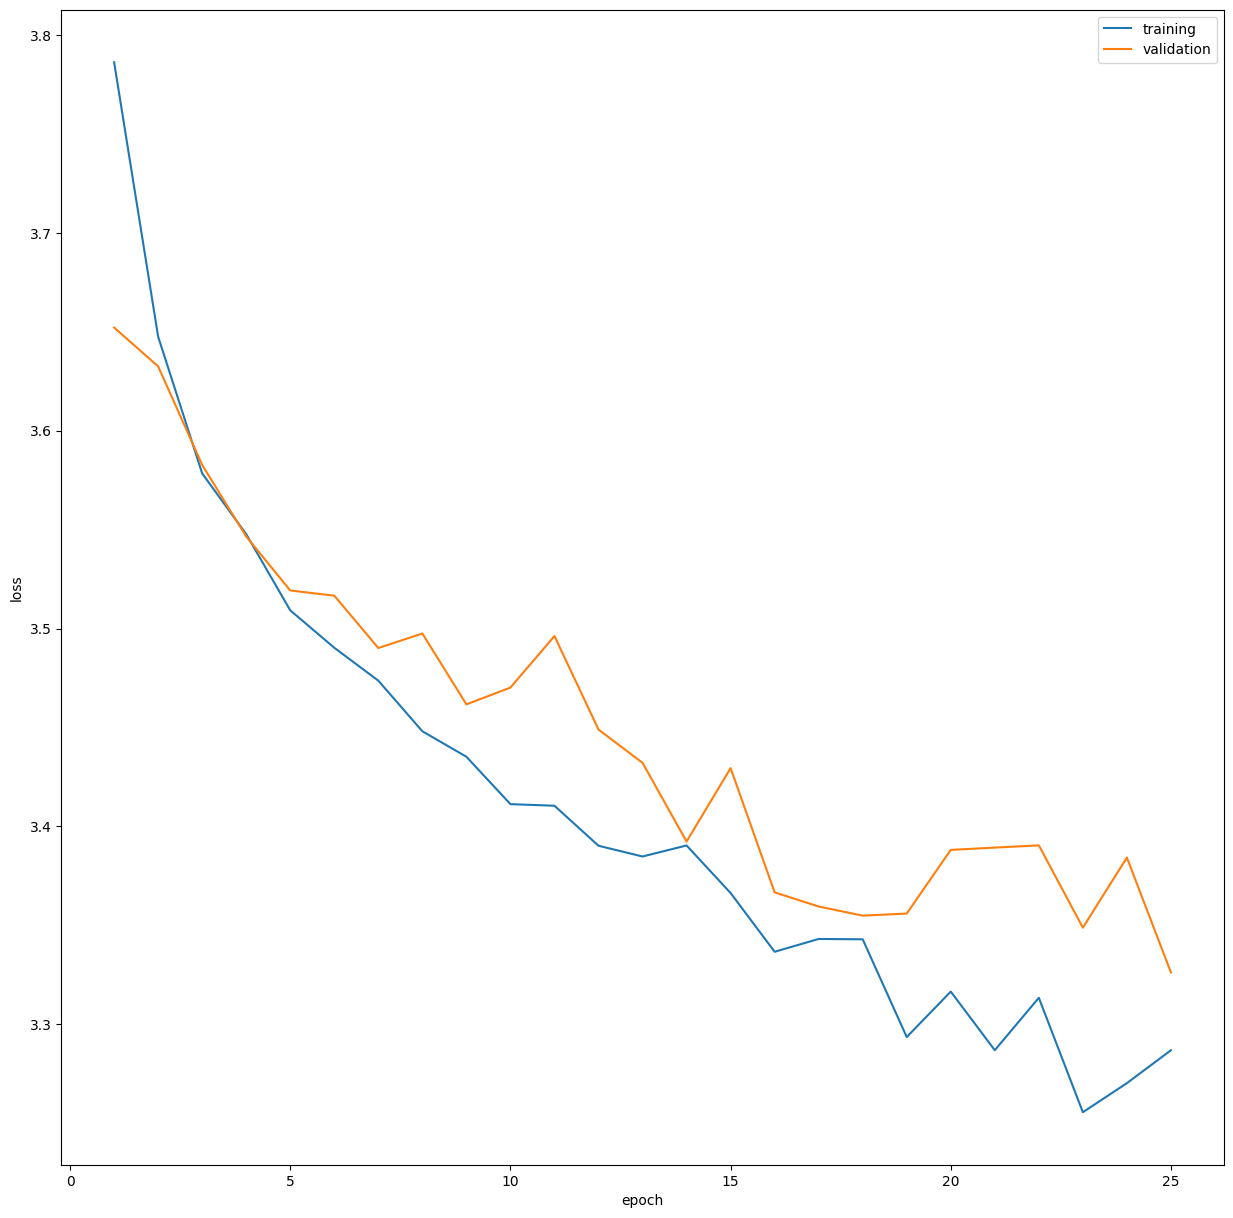

In [5]:
from TrainTestUtils import train, validate, plot_loss
EPOCHS = 25
epoch_nums = []
training_loss = []
validation_loss = []

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")
    # Call the train function
    train_loss = train(model, device, loss_criteria, train_loader, optimizer, epoch)
    # Call the validation function
    val_loss = validate(model, device, loss_criteria, val_loader)

    # Track losses and epochs
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    
plot_loss(epoch_nums, training_loss, validation_loss)

## Testing (performing predictions)

In [6]:
from TrainTestUtils import make_predictions, compute_accuracy

print("Getting predictions from test set...")
truelabels, predictions = make_predictions(model, test_loader, device)

accuracy = compute_accuracy(truelabels, predictions)
print(f"Test Set Accuracy: {accuracy:.2f}%")

Getting predictions from test set...
Test Set Accuracy: 12.98%
